In [31]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt


dataframe = pl.read_parquet("/run/media/mak/Heim/2024/20240826_week8/metashape/20241029_products_uav_data/output/extract/polygon_df/plot_8.parquet")
dataframe



shape: (19_258_665, 23)
┌────────────┬──────────┬──────────┬──────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Xw         ┆ Yw       ┆ band1    ┆ band2    ┆ … ┆ ycam       ┆ sunelev   ┆ saa       ┆ path      │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│ f64        ┆ f64      ┆ f32      ┆ f32      ┆   ┆ f32        ┆ f32       ┆ f32       ┆ str       │
╞════════════╪══════════╪══════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 563626.104 ┆ 5.7130e6 ┆ 0.015855 ┆ 0.045515 ┆ … ┆ 5.713036e6 ┆ 64.077271 ┆ 181.26986 ┆ IMG_0197_ │
│ 767        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 7         ┆ 6.tif     │
│ 563626.112 ┆ 5.7130e6 ┆ 0.021579 ┆ 0.063627 ┆ … ┆ 5.713036e6 ┆ 64.077271 ┆ 181.26986 ┆ IMG_0197_ │
│ 019        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 7         ┆ 6.tif     │
│ 563626.119 ┆ 5.7130e6 ┆ 0.029257 ┆ 0.089474 ┆ … ┆ 5.713036e6 ┆ 64.077271 ┆ 181.26986 ┆ IMG_0197_ │
│ 27         ┆          ┆          ┆          ┆   ┆            ┆           ┆ 7         ┆ 6.tif     │
│ 563626.126 ┆ 5.7130e6 ┆ 0.038768 ┆ 0.118516 ┆ … ┆ 5.713036e6 ┆ 64.077271 ┆ 181.26986 ┆ IMG_0197_ │
│ 521        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 7         ┆ 6.tif     │
│ 563626.133 ┆ 5.7130e6 ┆ 0.047851 ┆ 0.142683 ┆ … ┆ 5.713036e6 ┆ 64.077271 ┆ 181.26986 ┆ IMG_0197_ │
│ 773        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 7         ┆ 6.tif     │
│ …          ┆ …        ┆ …        ┆ …        ┆ … ┆ …          ┆ …         ┆ …         ┆ …         │
│ 563633.206 ┆ 5.7130e6 ┆ NaN      ┆ NaN      ┆ … ┆ 5.713052e6 ┆ 43.427704 ┆ 208.47375 ┆ IMG_0009_ │
│ 895        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 5         ┆ 6.tif     │
│ 563633.214 ┆ 5.7130e6 ┆ NaN      ┆ NaN      ┆ … ┆ 5.713052e6 ┆ 43.427704 ┆ 208.47375 ┆ IMG_0009_ │
│ 146        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 5         ┆ 6.tif     │
│ 563633.221 ┆ 5.7130e6 ┆ NaN      ┆ NaN      ┆ … ┆ 5.713052e6 ┆ 43.427704 ┆ 208.47375 ┆ IMG_0009_ │
│ 398        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 5         ┆ 6.tif     │
│ 563633.228 ┆ 5.7130e6 ┆ NaN      ┆ NaN      ┆ … ┆ 5.713052e6 ┆ 43.427704 ┆ 208.47375 ┆ IMG_0009_ │
│ 649        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 5         ┆ 6.tif     │
│ 563633.235 ┆ 5.7130e6 ┆ NaN      ┆ NaN      ┆ … ┆ 5.713052e6 ┆ 43.427704 ┆ 208.47375 ┆ IMG_0009_ │
│ 9          ┆          ┆          ┆          ┆   ┆            ┆           ┆ 5         ┆ 6.tif     │
└────────────┴──────────┴──────────┴──────────┴───┴────────────┴───────────┴───────────┴───────────┘

In [52]:
from typing import List, Tuple, Optional
import logging
from scipy.ndimage import gaussian_filter1d


def _kde1d_fast(
    v: np.ndarray,
    x_grid: np.ndarray,
    bw: float | None = None,
    bins: int = 1024,
    vmin: float | None = None,
    vmax: float | None = None,
) -> np.ndarray:
    """
    Approximate 1D KDE efficiently via histogram + Gaussian smoothing.

    Steps:
    1) Bin values into a fine histogram.
    2) Smooth counts with gaussian_filter1d using sigma derived from bandwidth.
    3) Interpolate smoothed density to x_grid and normalize to integrate to ~1.

    Args:
        v: 1D array of finite samples.
        x_grid: Points where the PDF should be evaluated.
        bw: Bandwidth in data units. If None, use Scott's rule.
        bins: Number of histogram bins for the smoothing grid.
        vmin, vmax: Optional clipping range. If None, inferred from data.

    Returns:
        y_pdf evaluated at x_grid (approximately normalized).
    """
    v = v[np.isfinite(v)]
    if v.size < 5:
        return np.zeros_like(x_grid)

    # Range and histogram grid
    lo = np.min(v) if vmin is None else float(vmin)
    hi = np.max(v) if vmax is None else float(vmax)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = float(np.nanmin(v)), float(np.nanmax(v))
        if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
            return np.zeros_like(x_grid)

    edges = np.linspace(lo, hi, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    counts, _ = np.histogram(v, bins=edges)

    # Bandwidth: Scott's rule if not provided
    if bw is None:
        s = np.std(v)
        n = v.size
        # Scott's rule: bw = 1.06 * s * n^(-1/5); fallback if s==0
        bw = 1.06 * (s if s > 0 else (hi - lo) / 6.0) * (n ** (-1.0 / 5.0))
        if bw <= 0 or not np.isfinite(bw):
            bw = max((hi - lo) / 100.0, 1e-12)

    # Convert bandwidth to sigma in bins
    bin_width = centers[1] - centers[0]
    sigma_bins = max(bw / bin_width, 1e-6)

    # Smooth counts
    smooth = gaussian_filter1d(counts.astype(float), sigma=sigma_bins, mode="nearest")

    # Convert to density (divide by N and bin width)
    density_centers = smooth / (v.size * bin_width)

    # Interpolate to requested x_grid
    y_pdf = np.interp(x_grid, centers, density_centers, left=0.0, right=0.0)

    # Normalize lightly to ensure area ≈ 1 over [lo, hi]
    area = np.trapz(y_pdf, x_grid)
    if area > 0 and np.isfinite(area):
        y_pdf = y_pdf / area

    return y_pdf

def angle_kde_plot(
    df,
    band: str,
    bins: Tuple[int, int],
    angle: str,
    xlim: Optional[Tuple[float, float]],
    points: int,
    linewidth: float,
    colors: Optional[List[str]],
    dpi: int,
    ) -> None:
    try:
        df = df.drop_nulls().drop_nans()
        if xlim is not None:
            x_min, x_max = xlim
        else:
            x_min = df.select(pl.col(band).quantile(0.01)).item()
            x_max = df.select(pl.col(band).quantile(0.98)).item()
            print(x_min, x_max)
        x_grid = np.linspace(x_min, x_max, int(points))
        fig_k, ax_k = plt.subplots(figsize=(10, 6), dpi=dpi)

        cycle = colors or plt.rcParams["axes.prop_cycle"].by_key().get("color", None)

        i = 0
        for bin in bins:

            filtered_df = df.filter(
                pl.col(angle)>bin[0],
                pl.col(angle)<bin[1],
            )

            v = filtered_df[band].to_numpy()
            # Restrict to finite values within [x_min, x_max] to match chart limits
            v = v[np.isfinite(v)]
            v = v[(v >= x_min) & (v <= x_max)]
            if v.size < 5:
                continue

            # Fast KDE via histogram smoothing (orders of magnitude faster than gaussian_kde on big data)
            y_pdf = _kde1d_fast(
                v,
                x_grid,
                bw=None,  # or set a float bandwidth in data units (e.g., 0.01)
                bins=5128,  # can lower to 512 for even faster
                vmin=x_min,
                vmax=x_max,
            )

            color = None
            if cycle and i < len(cycle):
                color = cycle[i]
            ax_k.plot(x_grid, y_pdf, label=f"{bin[0]},{bin[1]}", linewidth=linewidth, color=color)
            i+=1

        ax_k.set_xlim(x_min, x_max)
        ax_k.set_ylim(bottom=0.0)
        ax_k.set_xlabel("Reflectance")
        ax_k.set_ylabel("Density (KDE)")
        ax_k.set_title(f"{band} value distributions(KDE) by different {angle} bins ")
        ax_k.grid(True, alpha=0.3)
        ax_k.legend(ncol=2)
        fig_k.tight_layout()
        fig_k.show()
    except Exception as e:
        logging.error(f"[plotting_raster] Failed to create band KDE chart: {e}")



0.0028277095407247543 0.08164452016353607


/tmp/ipykernel_371621/2631117297.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(y_pdf, x_grid)
/tmp/ipykernel_371621/2631117297.py:140: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_k.show()


0.010450415313243866 0.19510677456855774
0.004672456998378038 0.11847195029258728
0.03452929109334946 0.3790273070335388
0.11176793277263641 0.7234895825386047


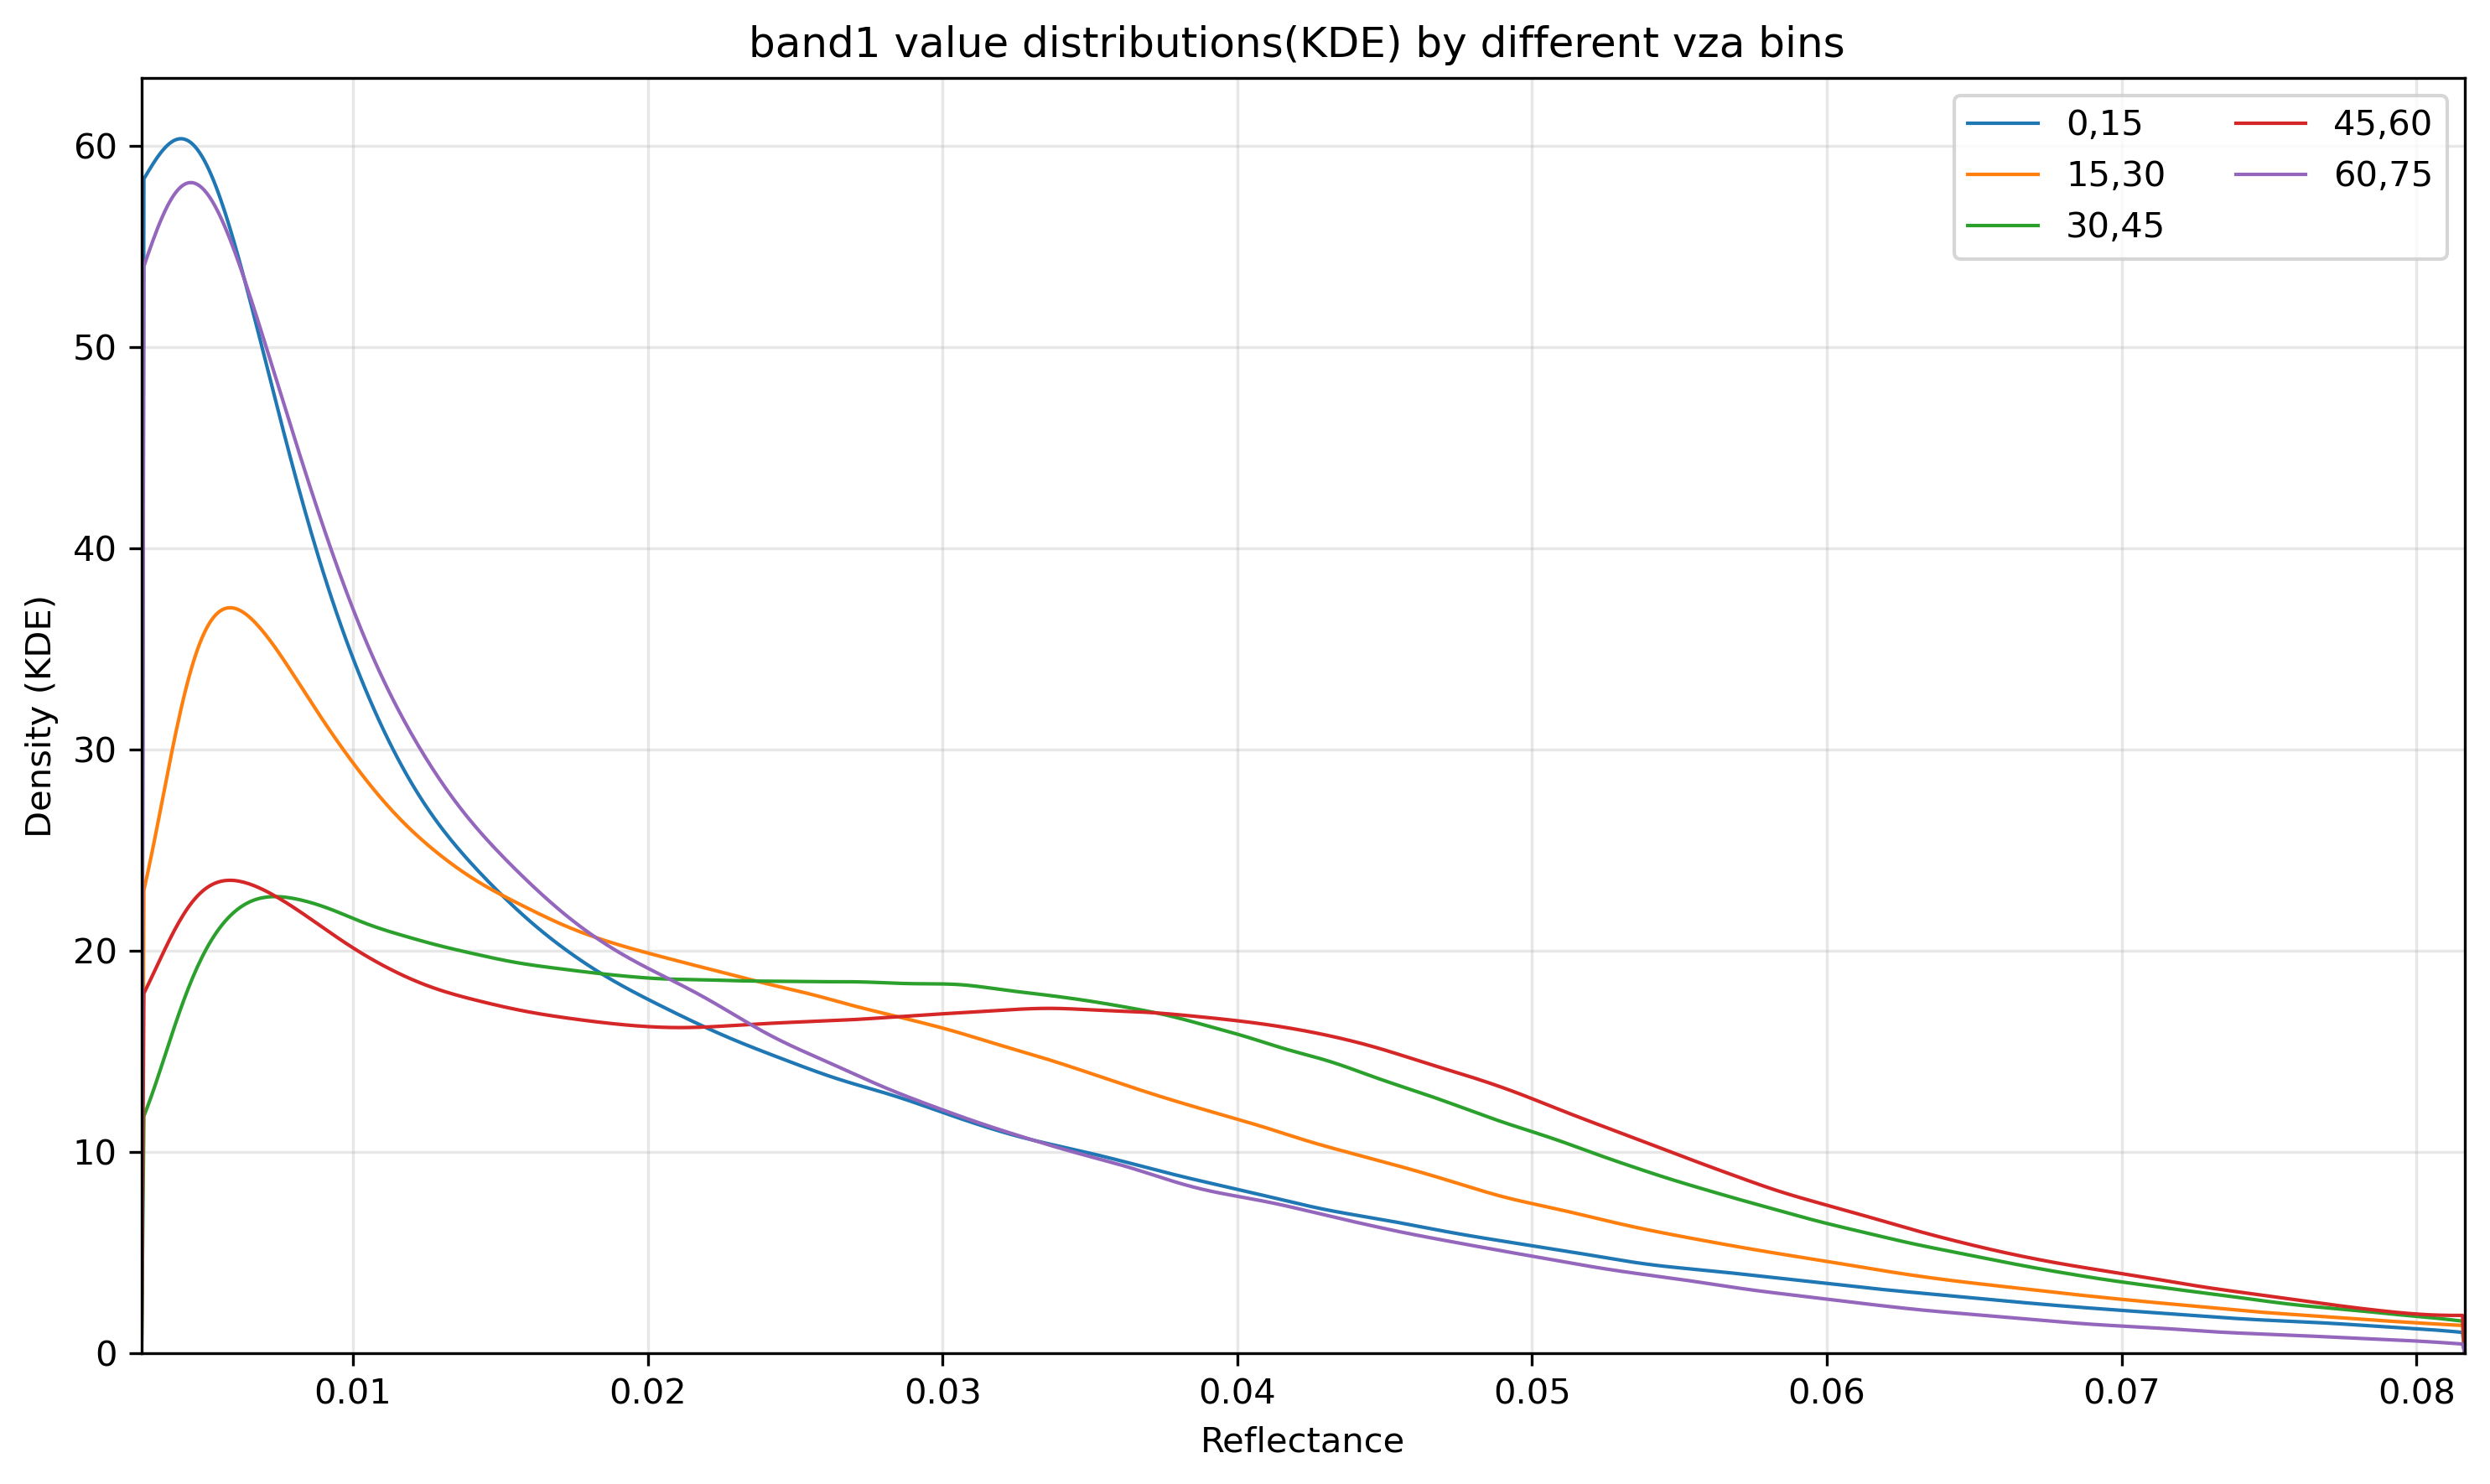

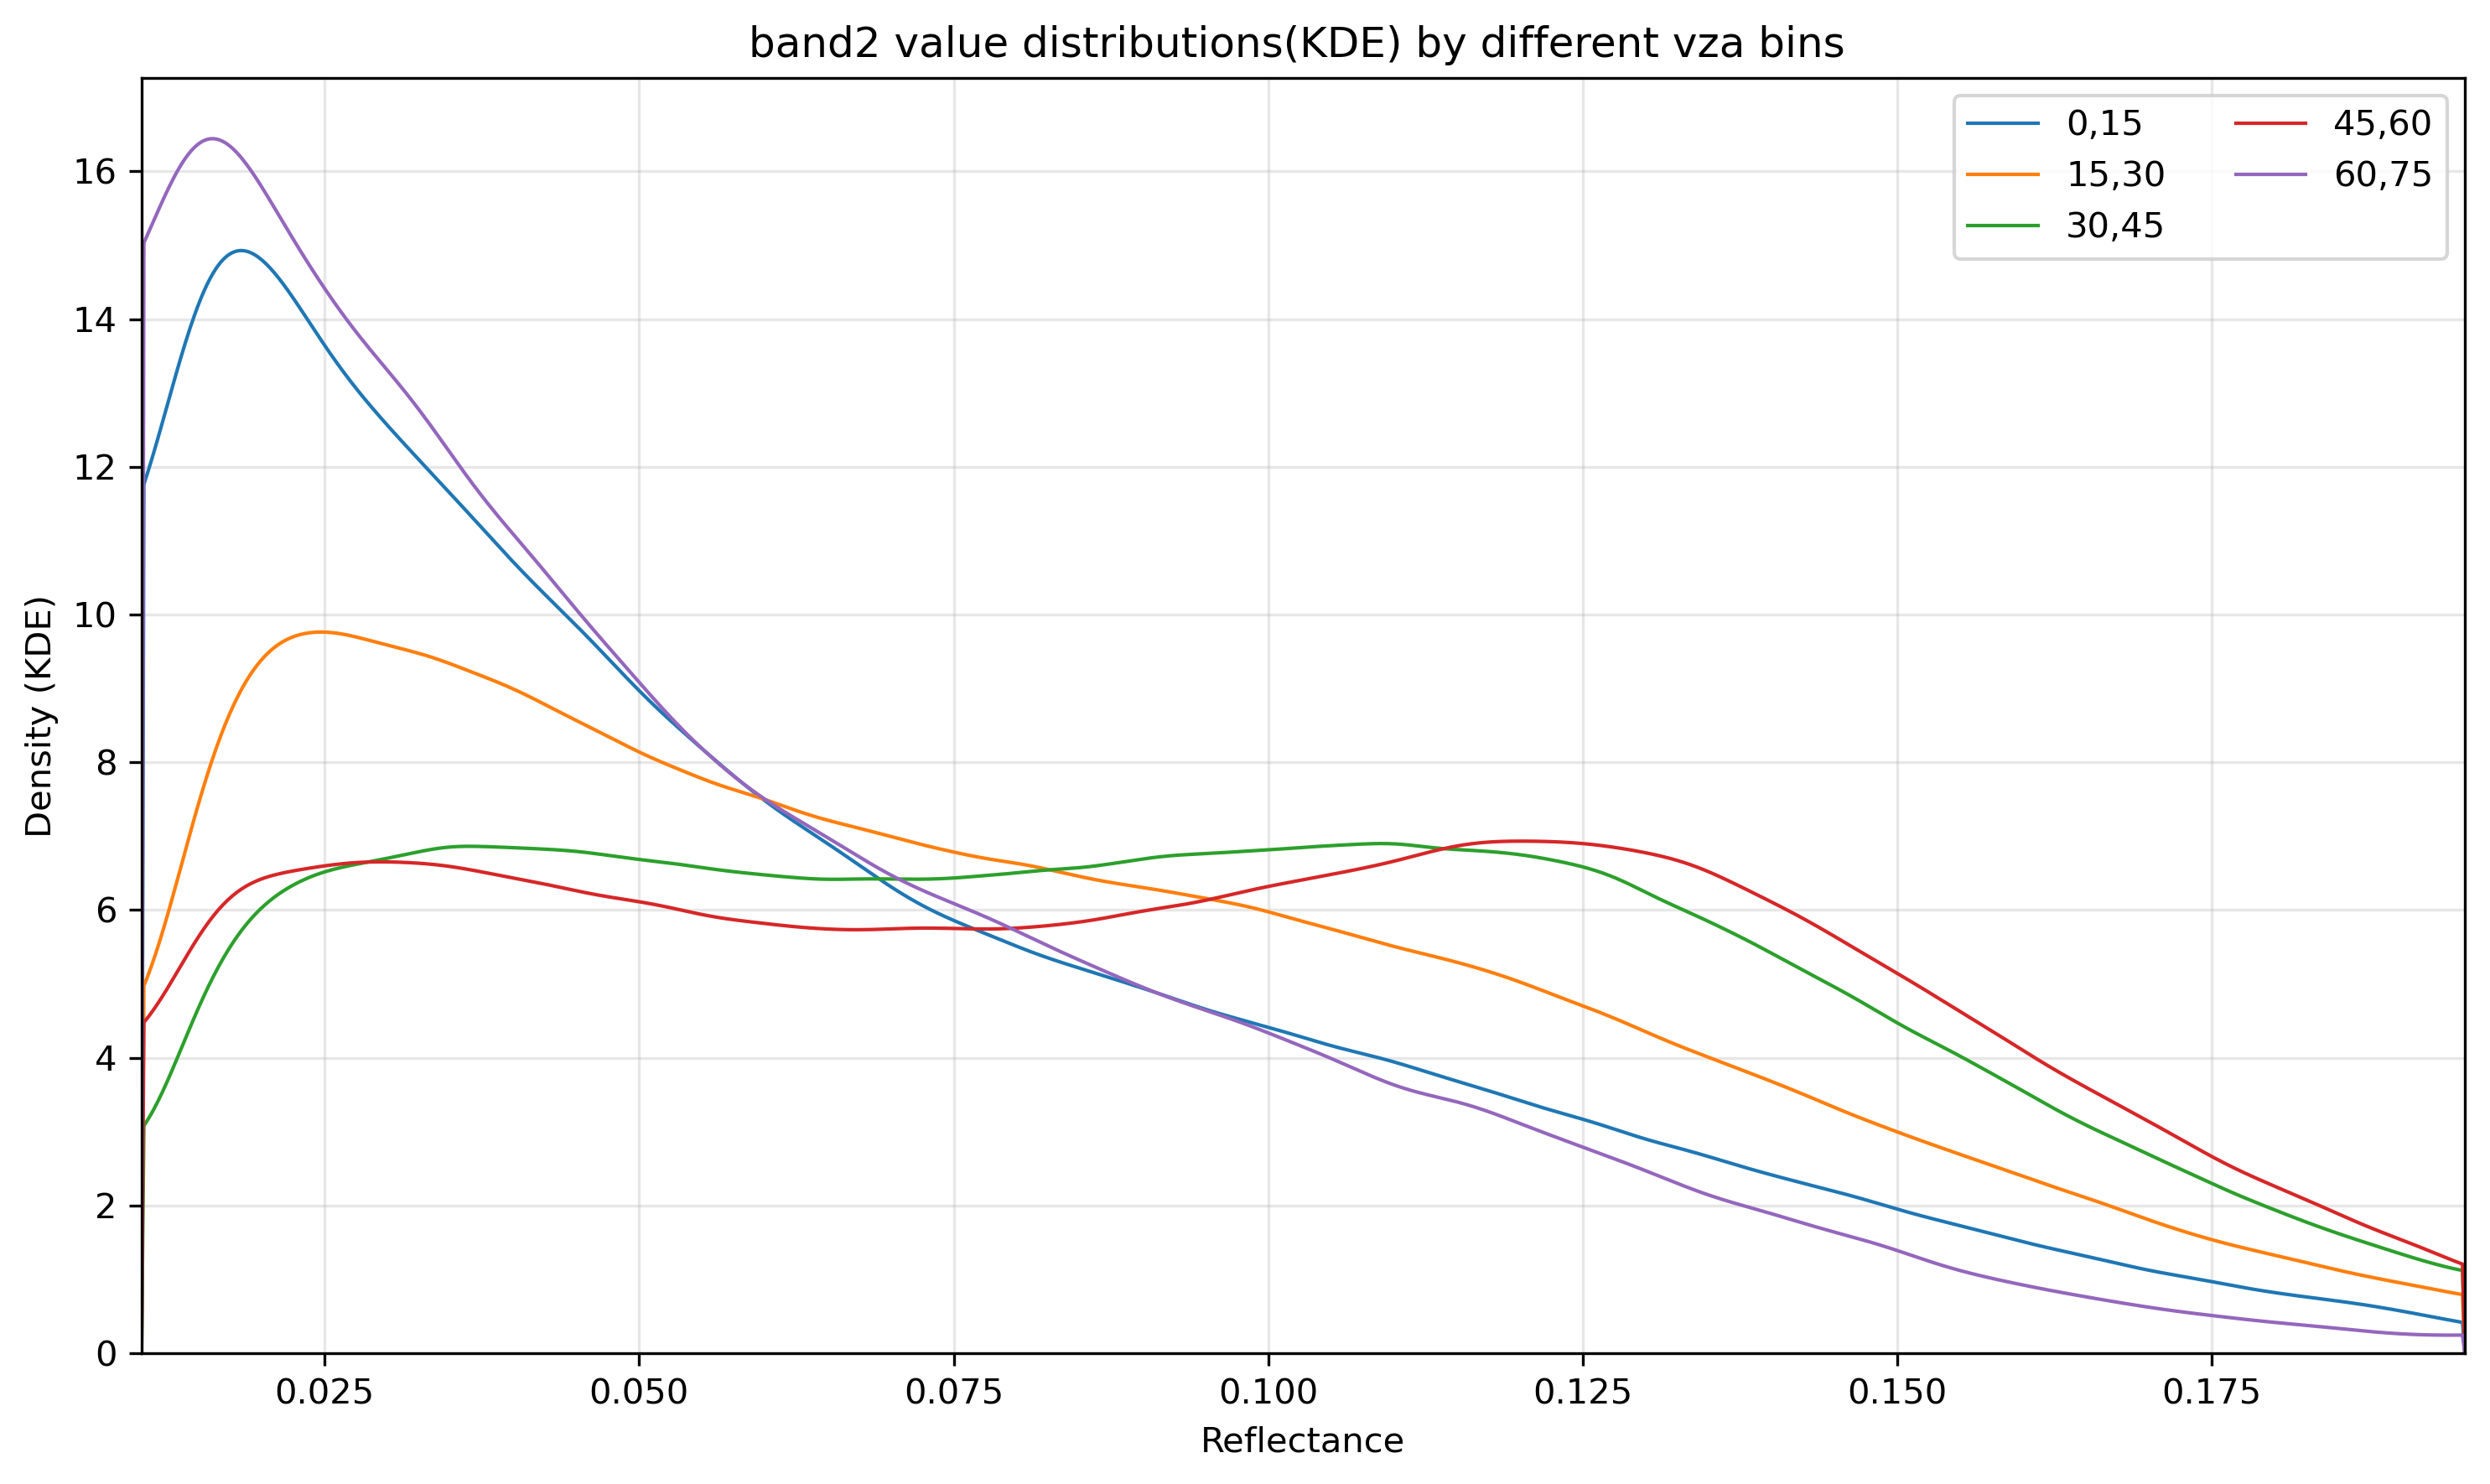

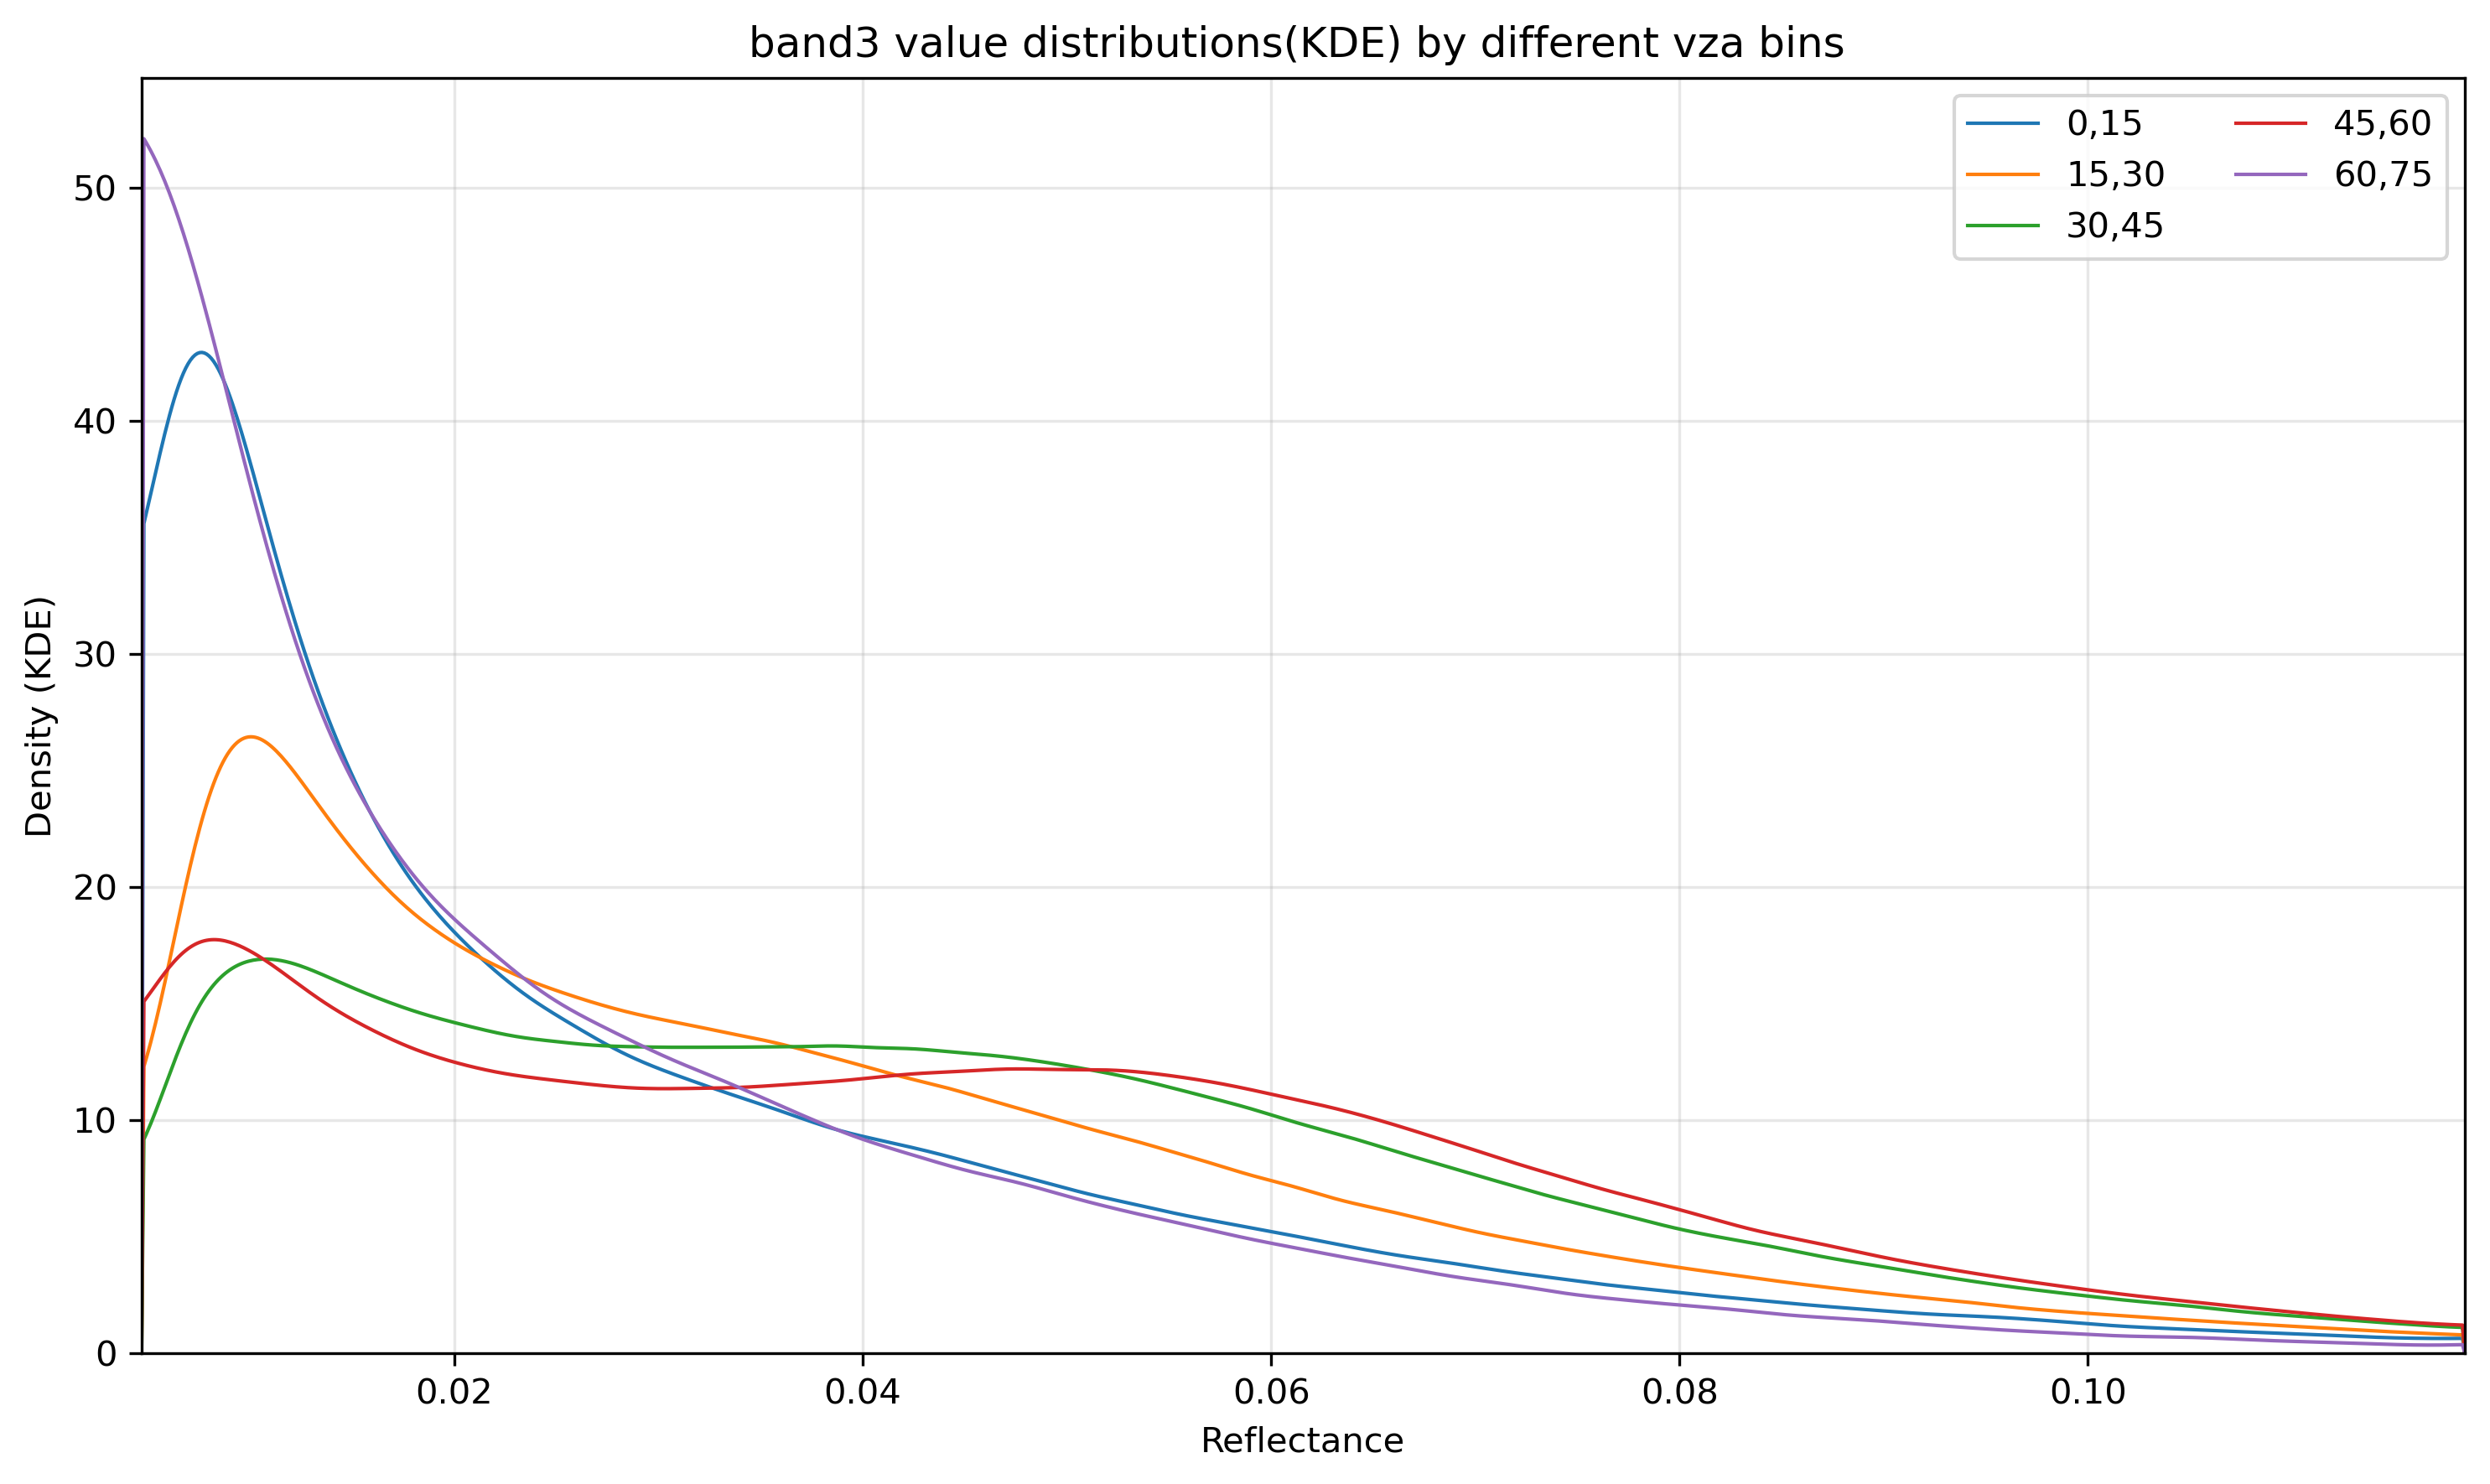

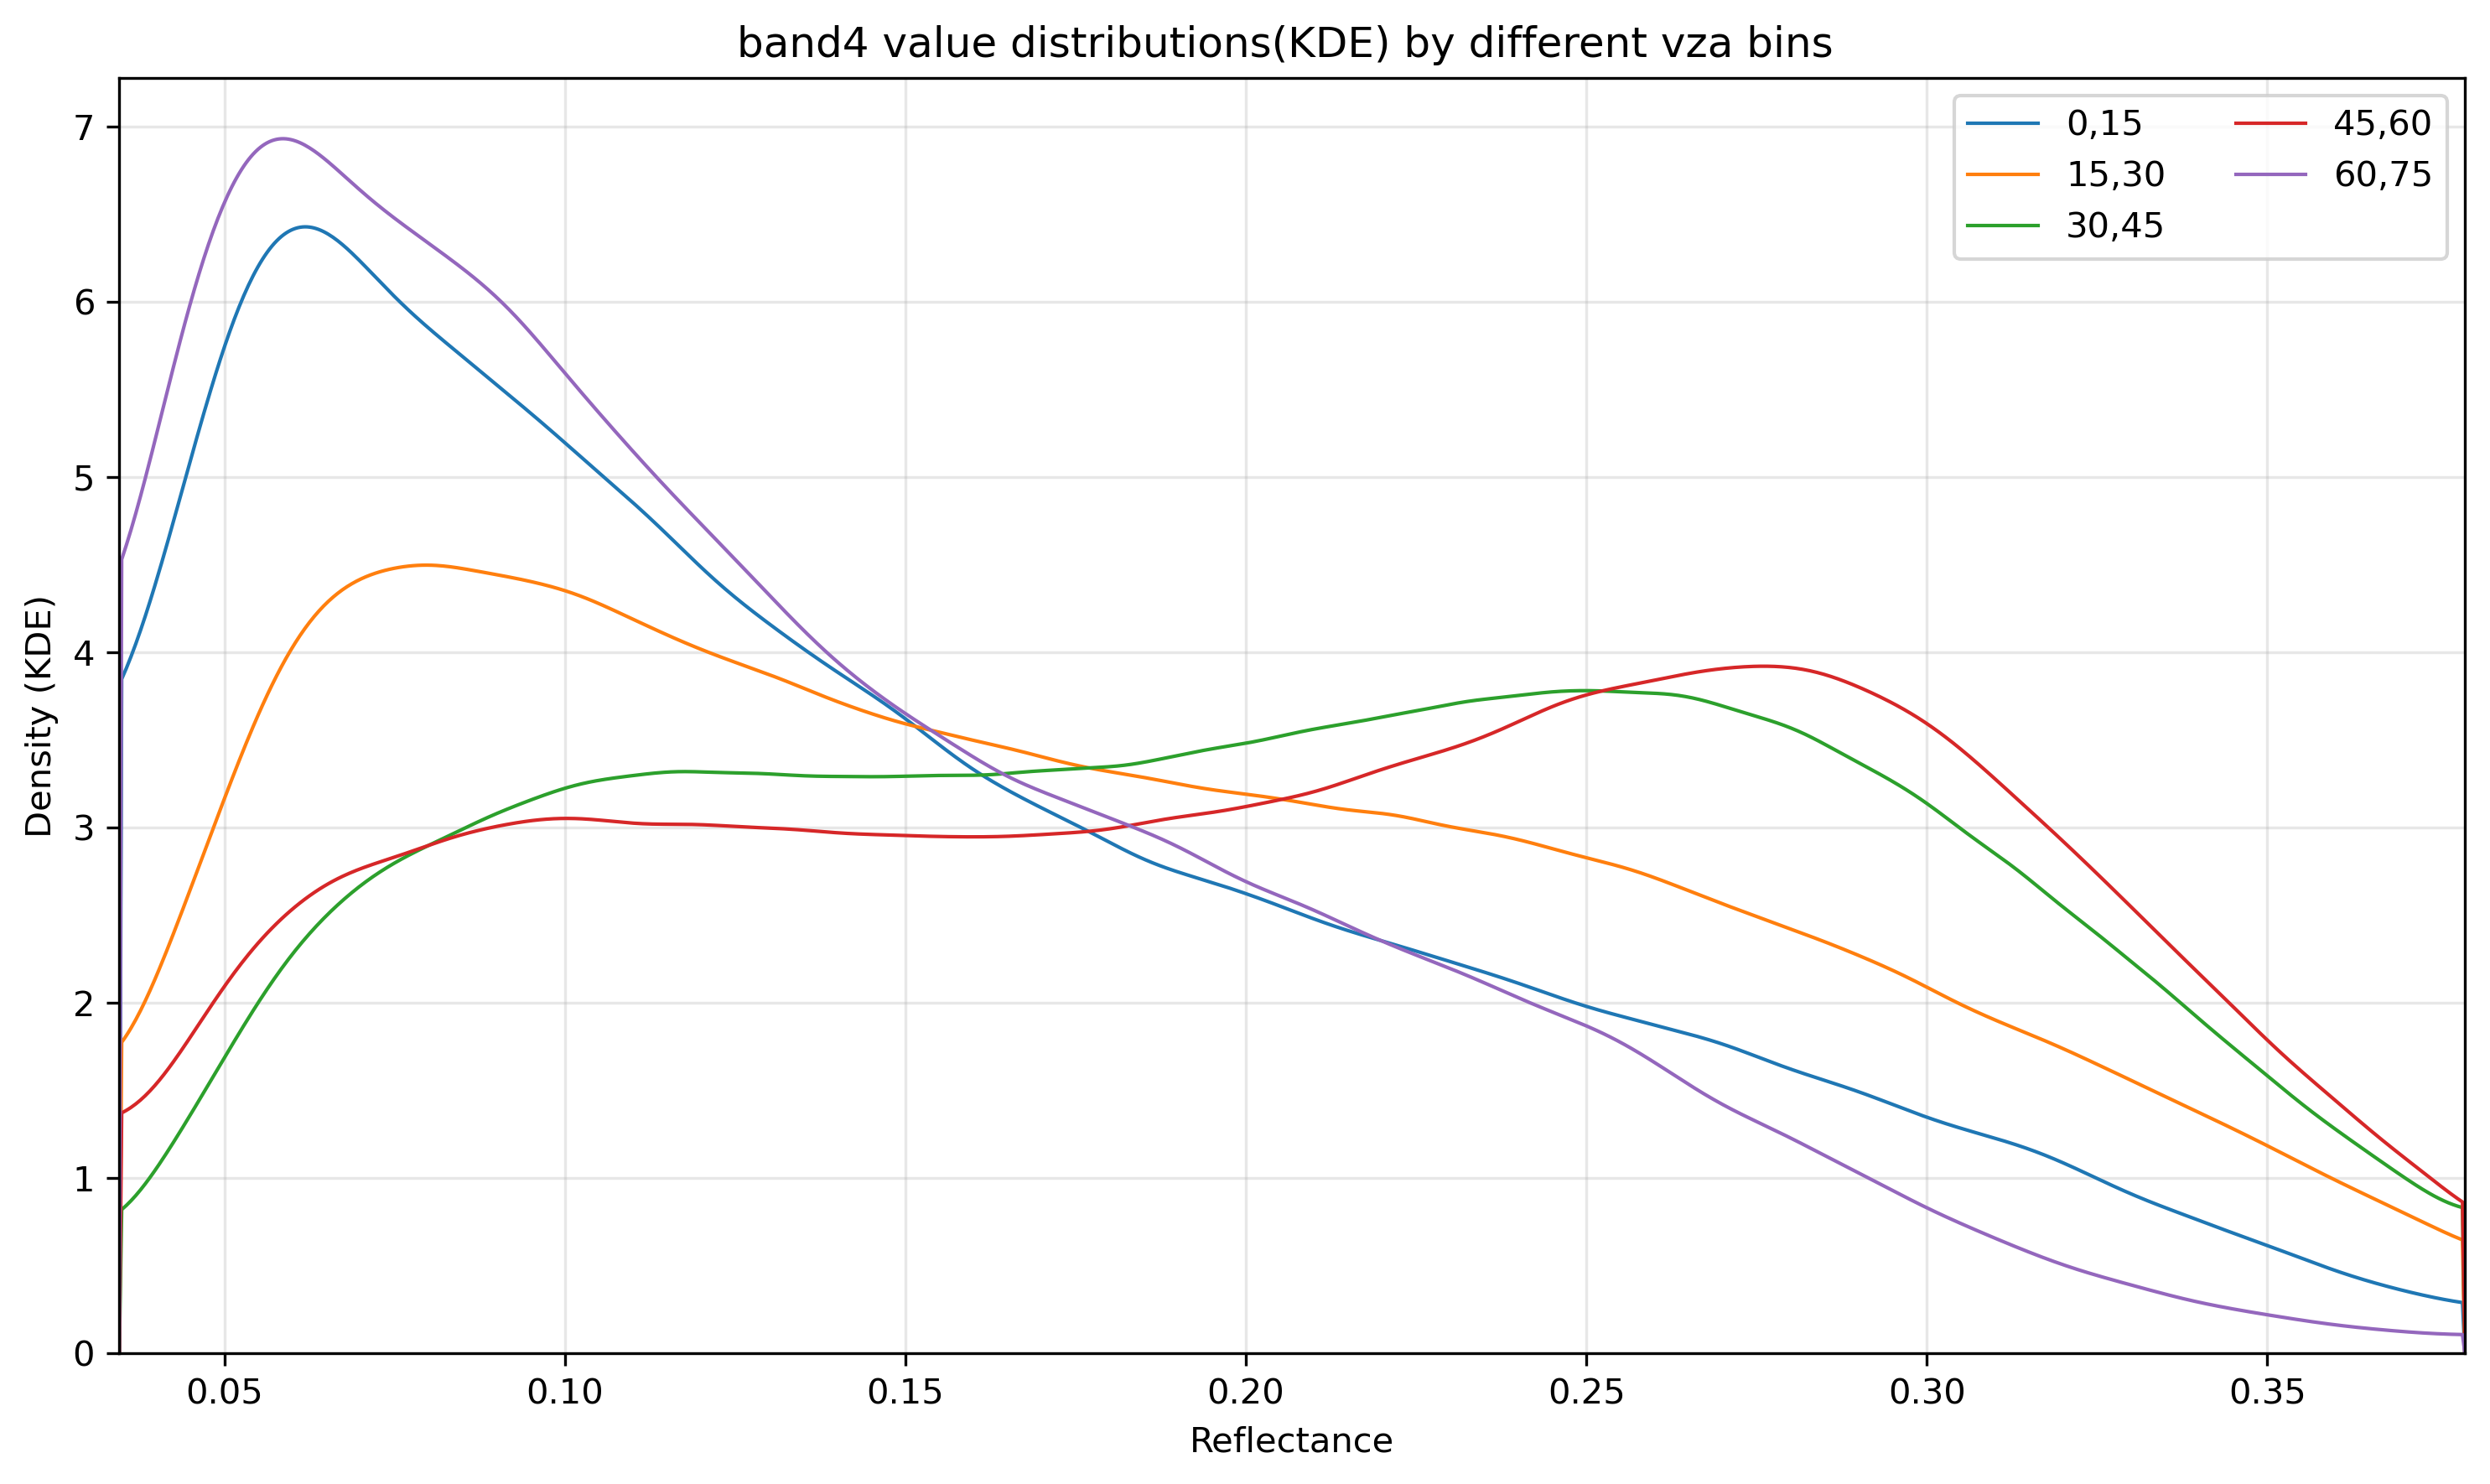

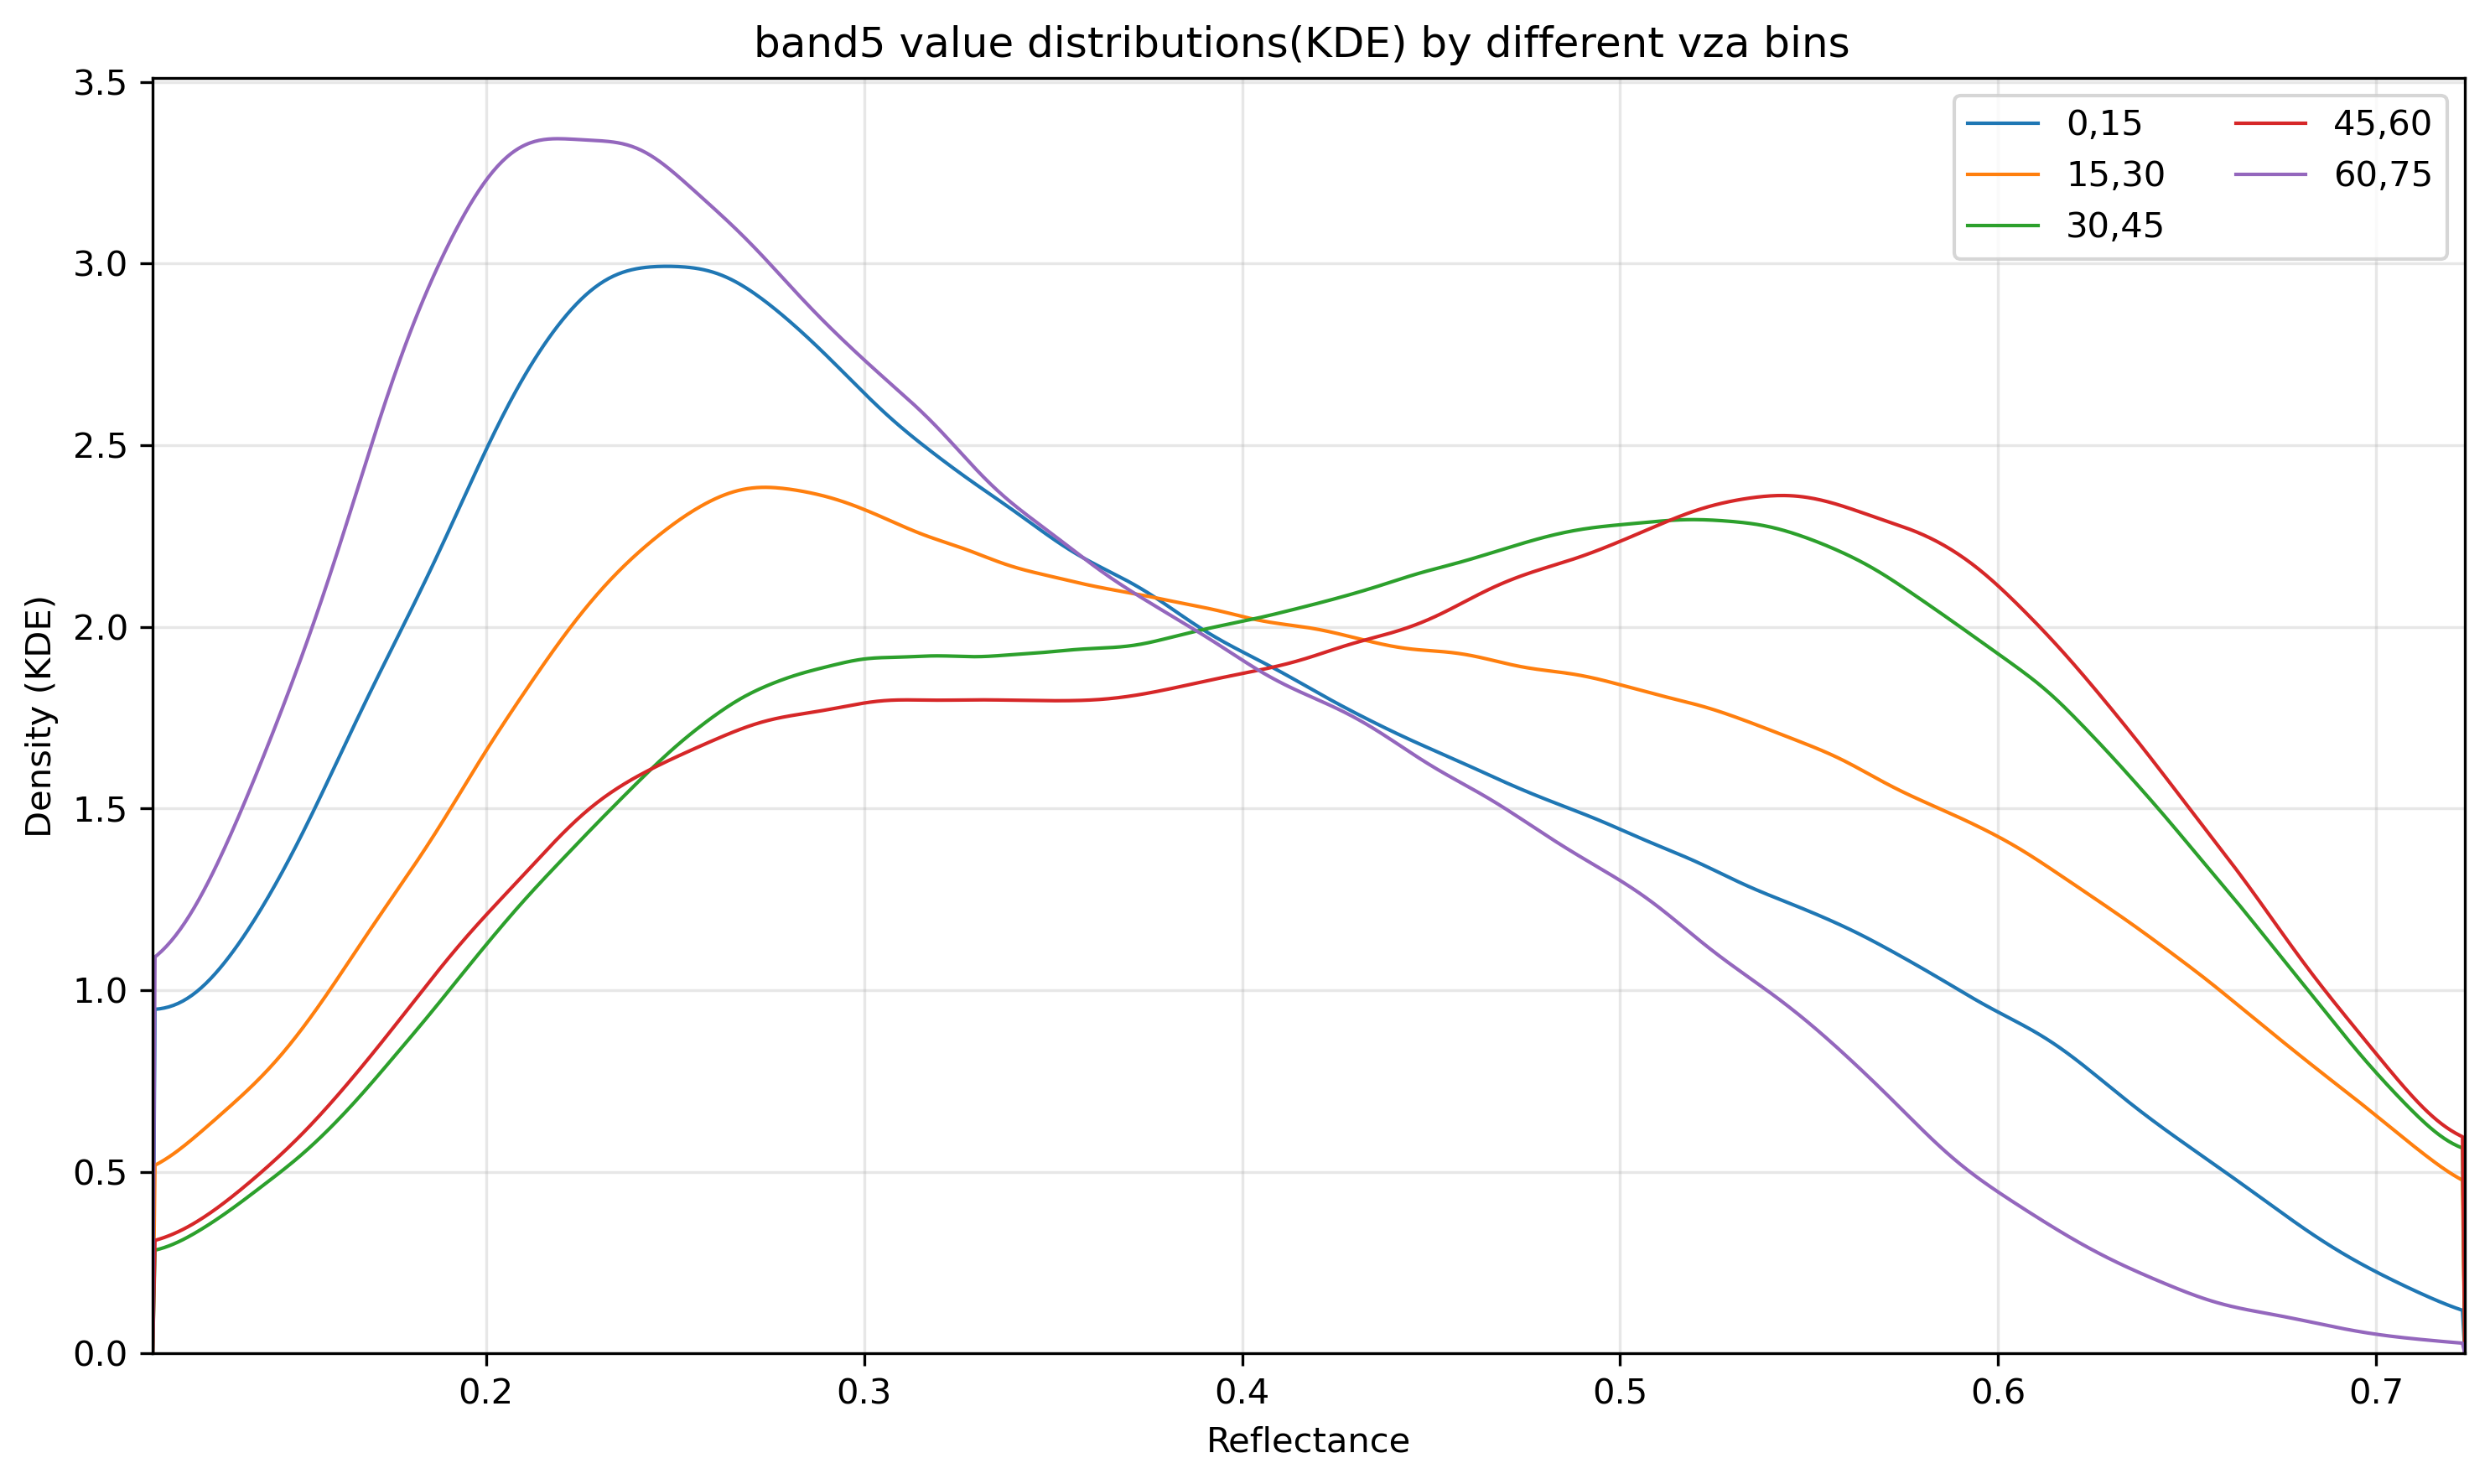

In [53]:
vza_bins = [(0,15),(15,30),(30,45),(45,60),(60,75)]

for band in [f"band{i}" for i in range(1,6)]:
    angle_kde_plot(dataframe, band=band, bins=vza_bins, points=1000, linewidth=1, colors=None, dpi=300, xlim=None, angle='vza')

0.0028277095407247543 0.08164452016353607


/tmp/ipykernel_371621/2718039885.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(y_pdf, x_grid)
/tmp/ipykernel_371621/2718039885.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_k.show()


0.010450415313243866 0.19510677456855774
0.004672456998378038 0.11847195029258728
0.03452929109334946 0.3790273070335388
0.11176793277263641 0.7234895825386047


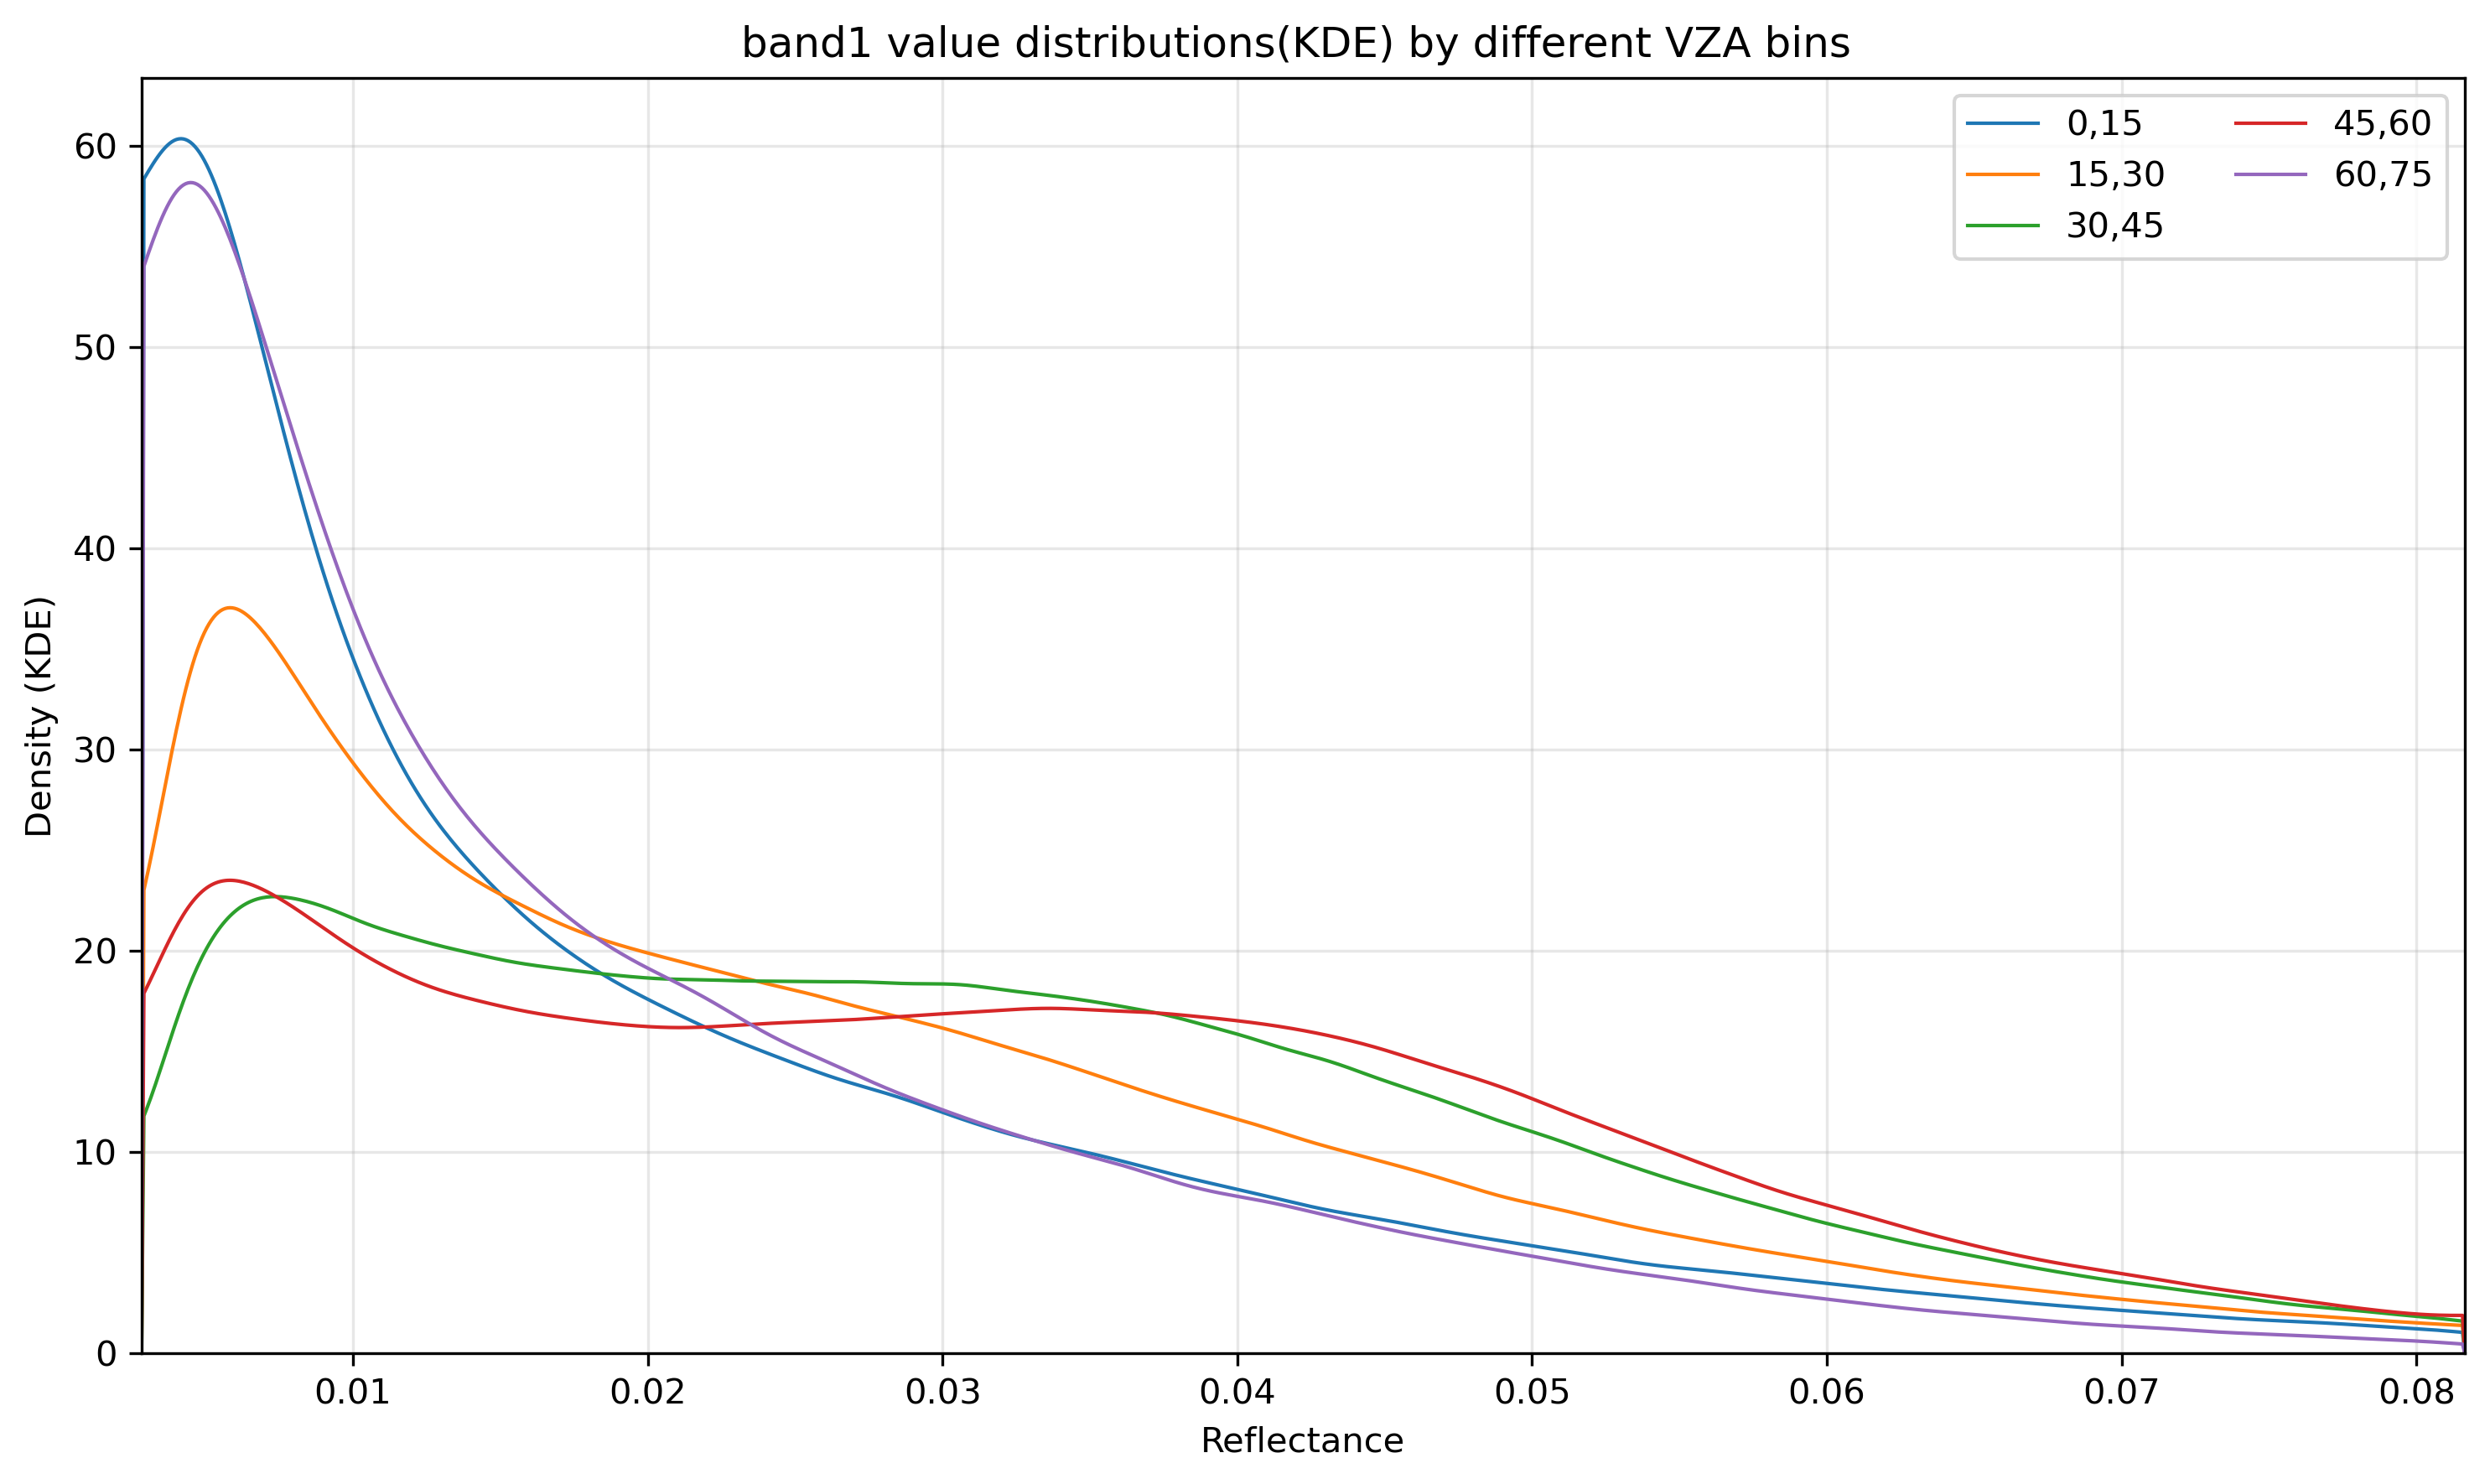

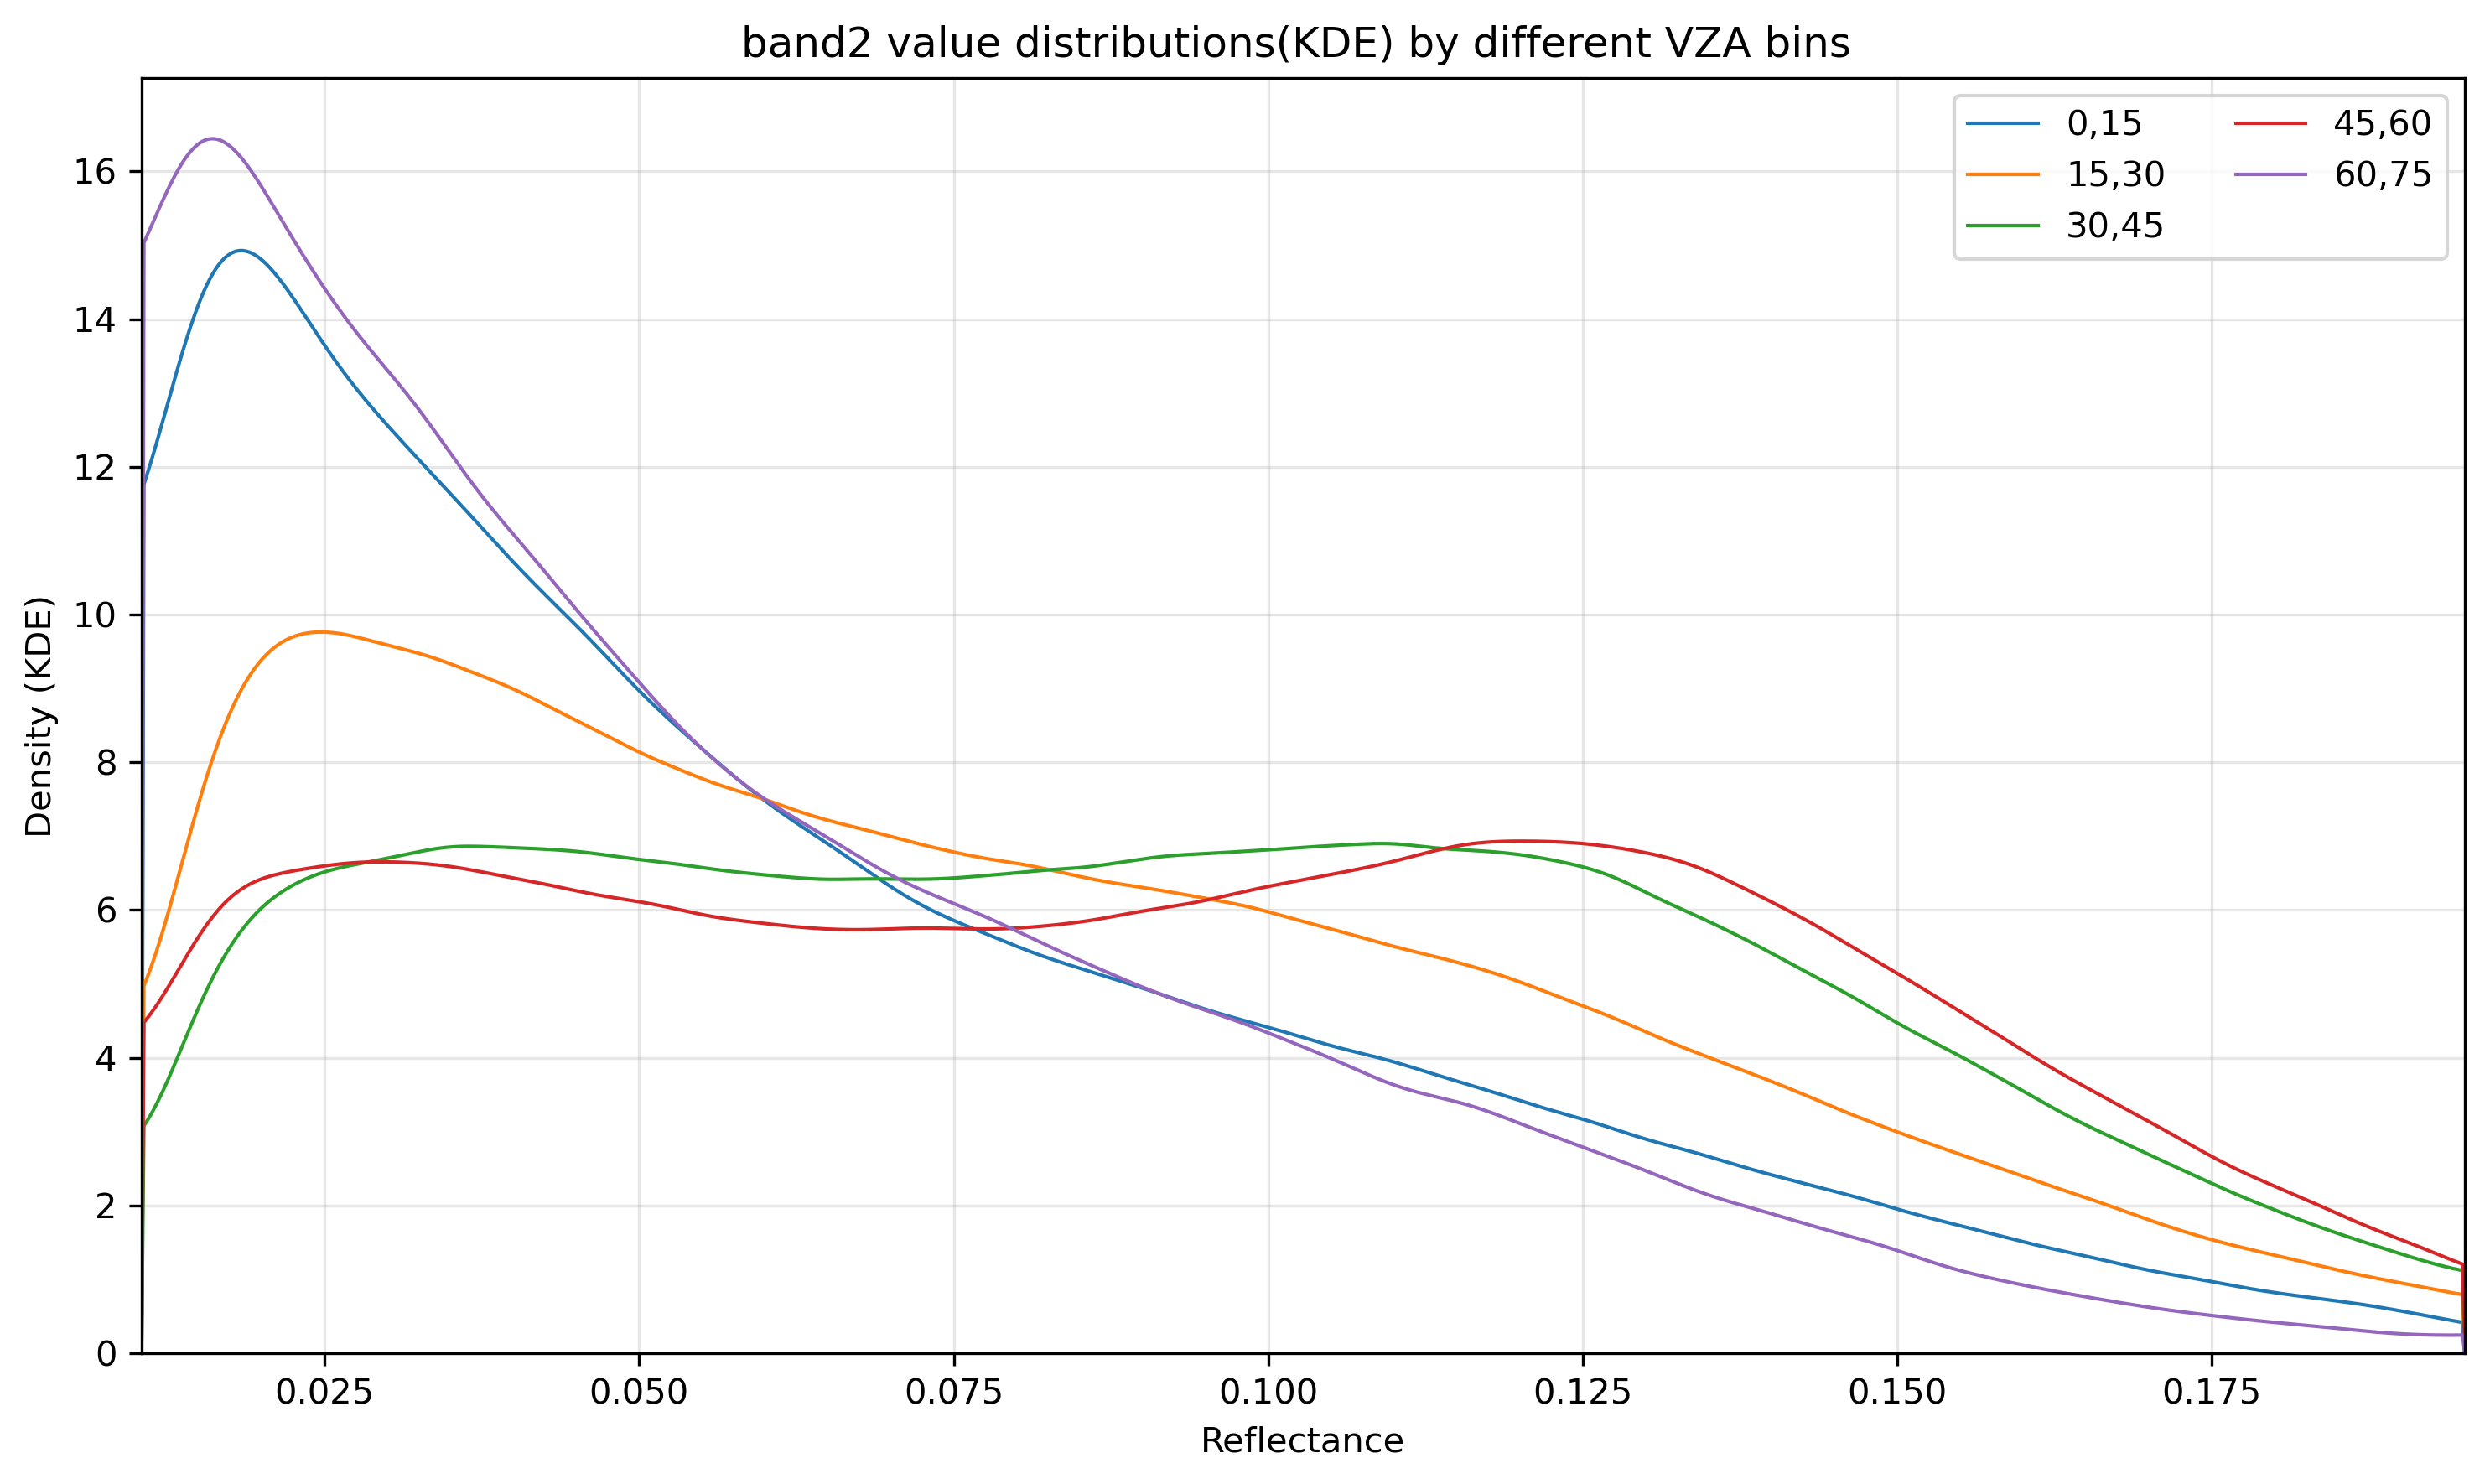

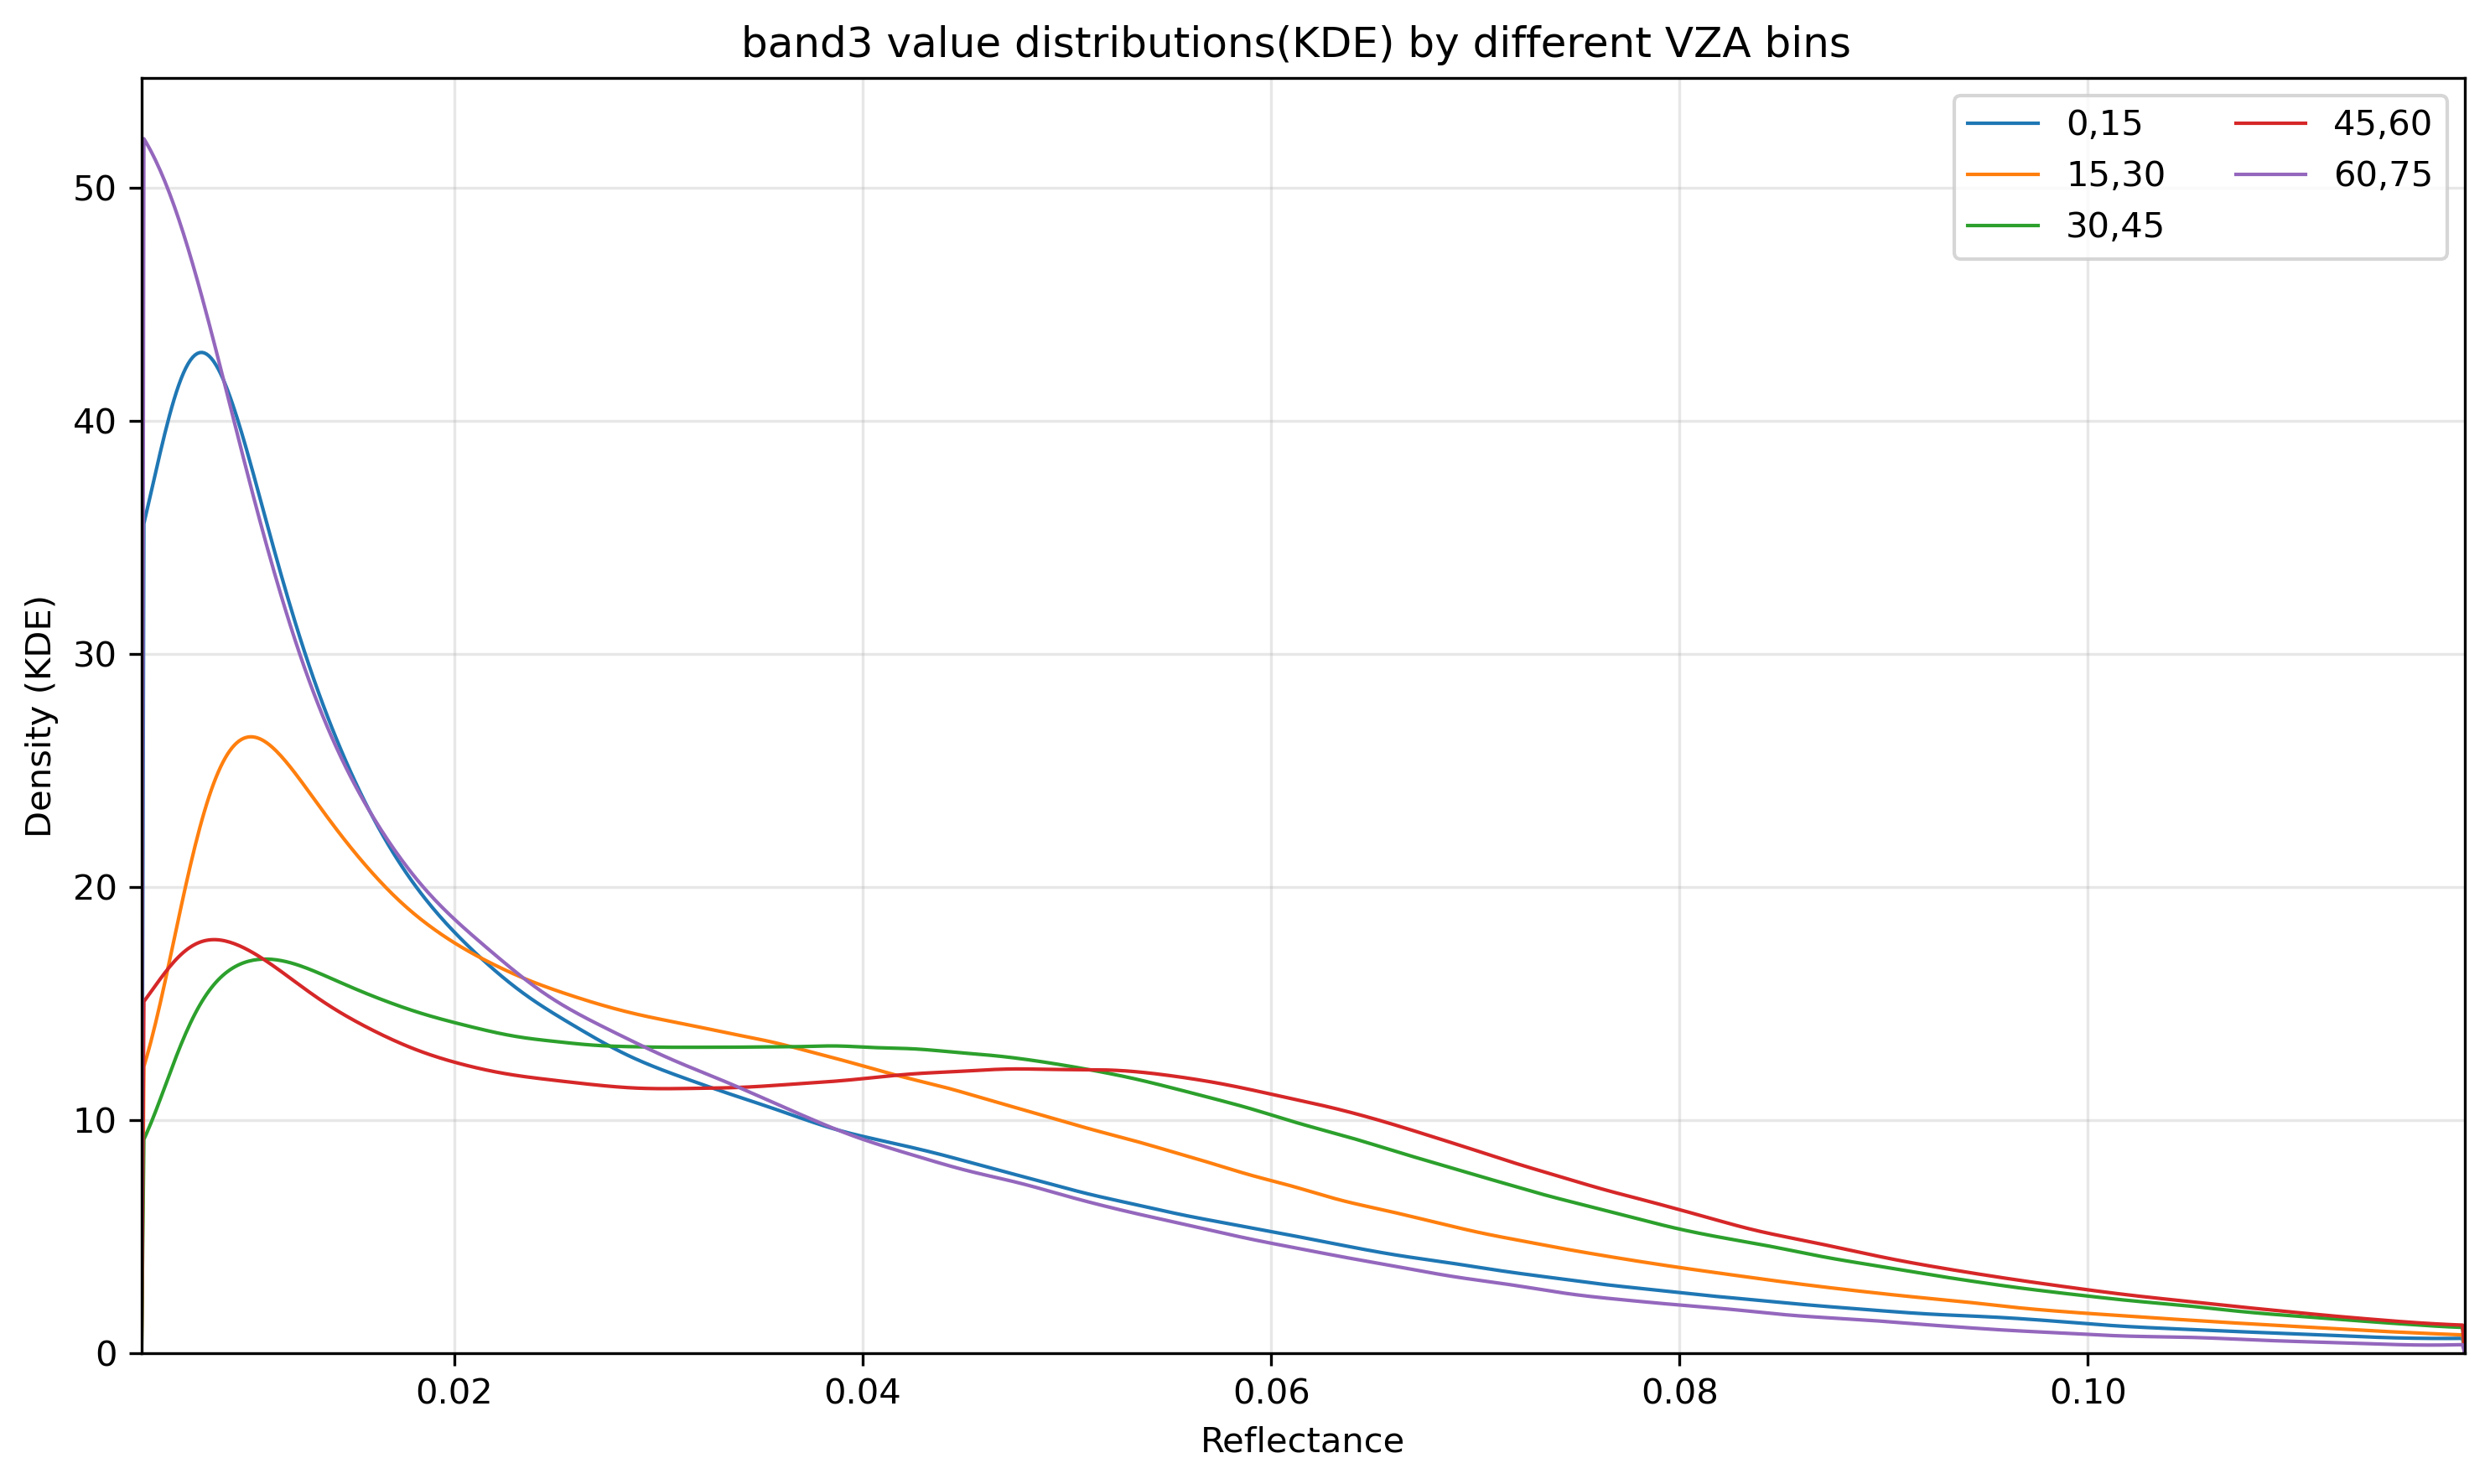

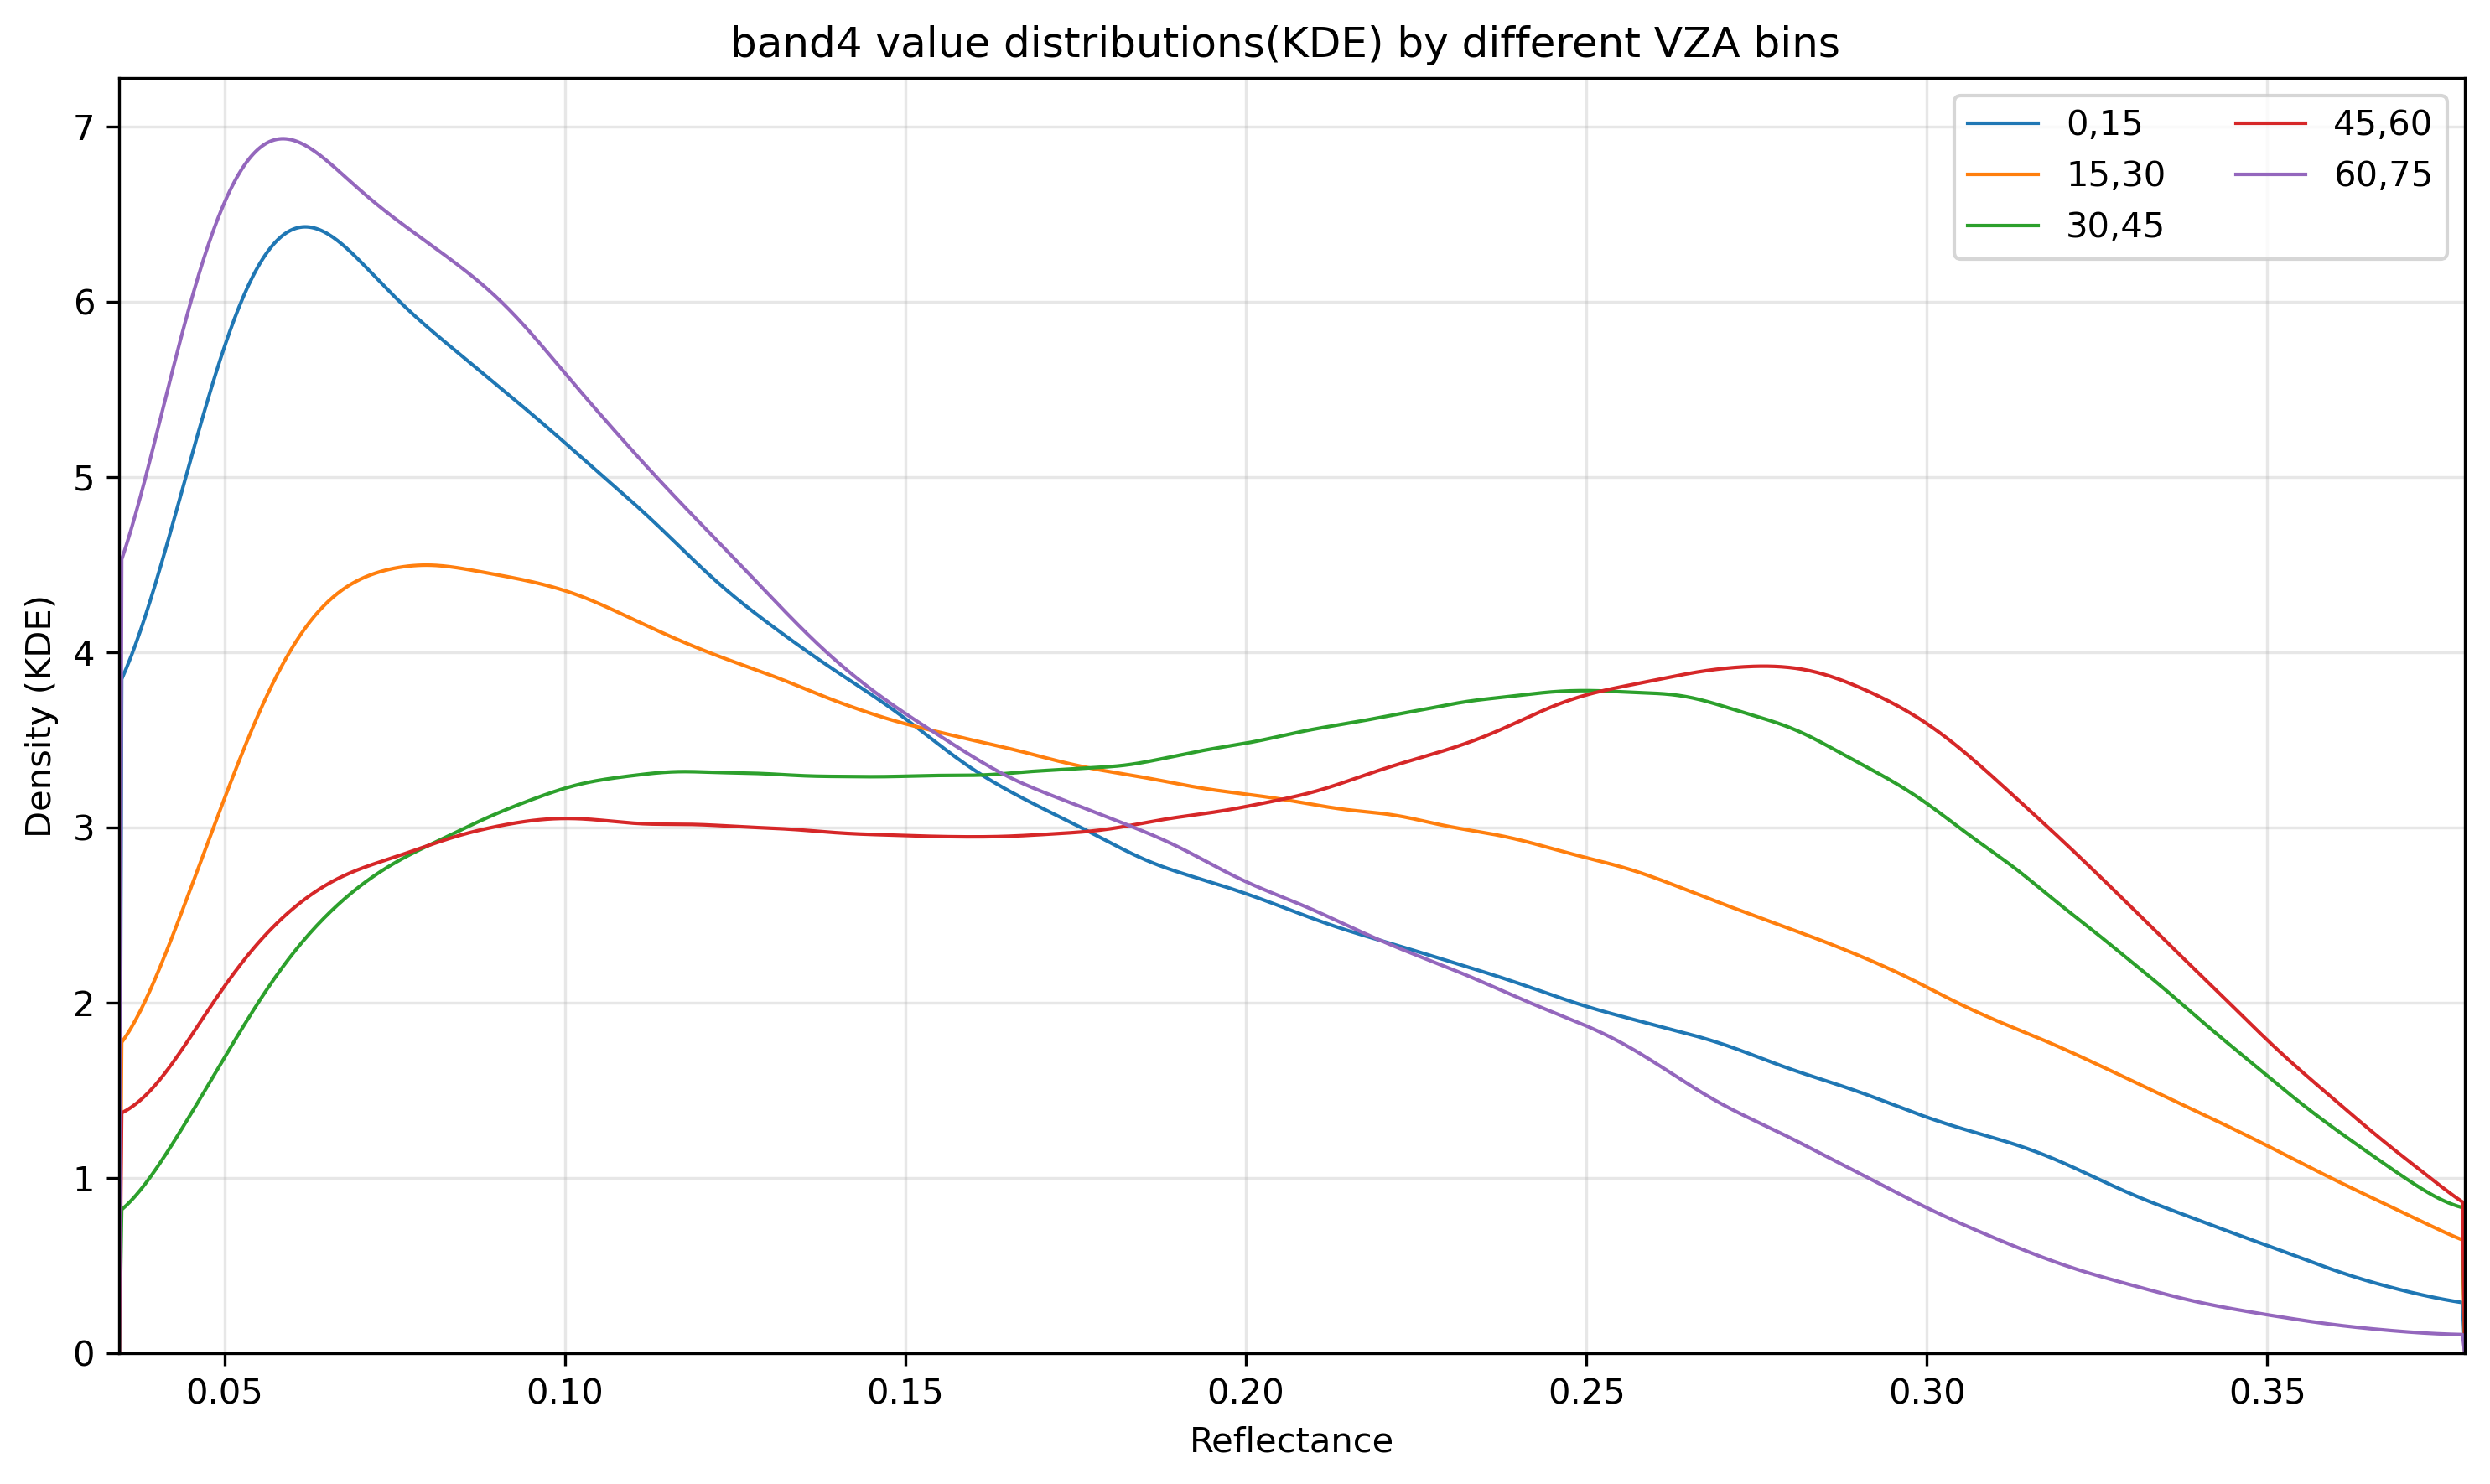

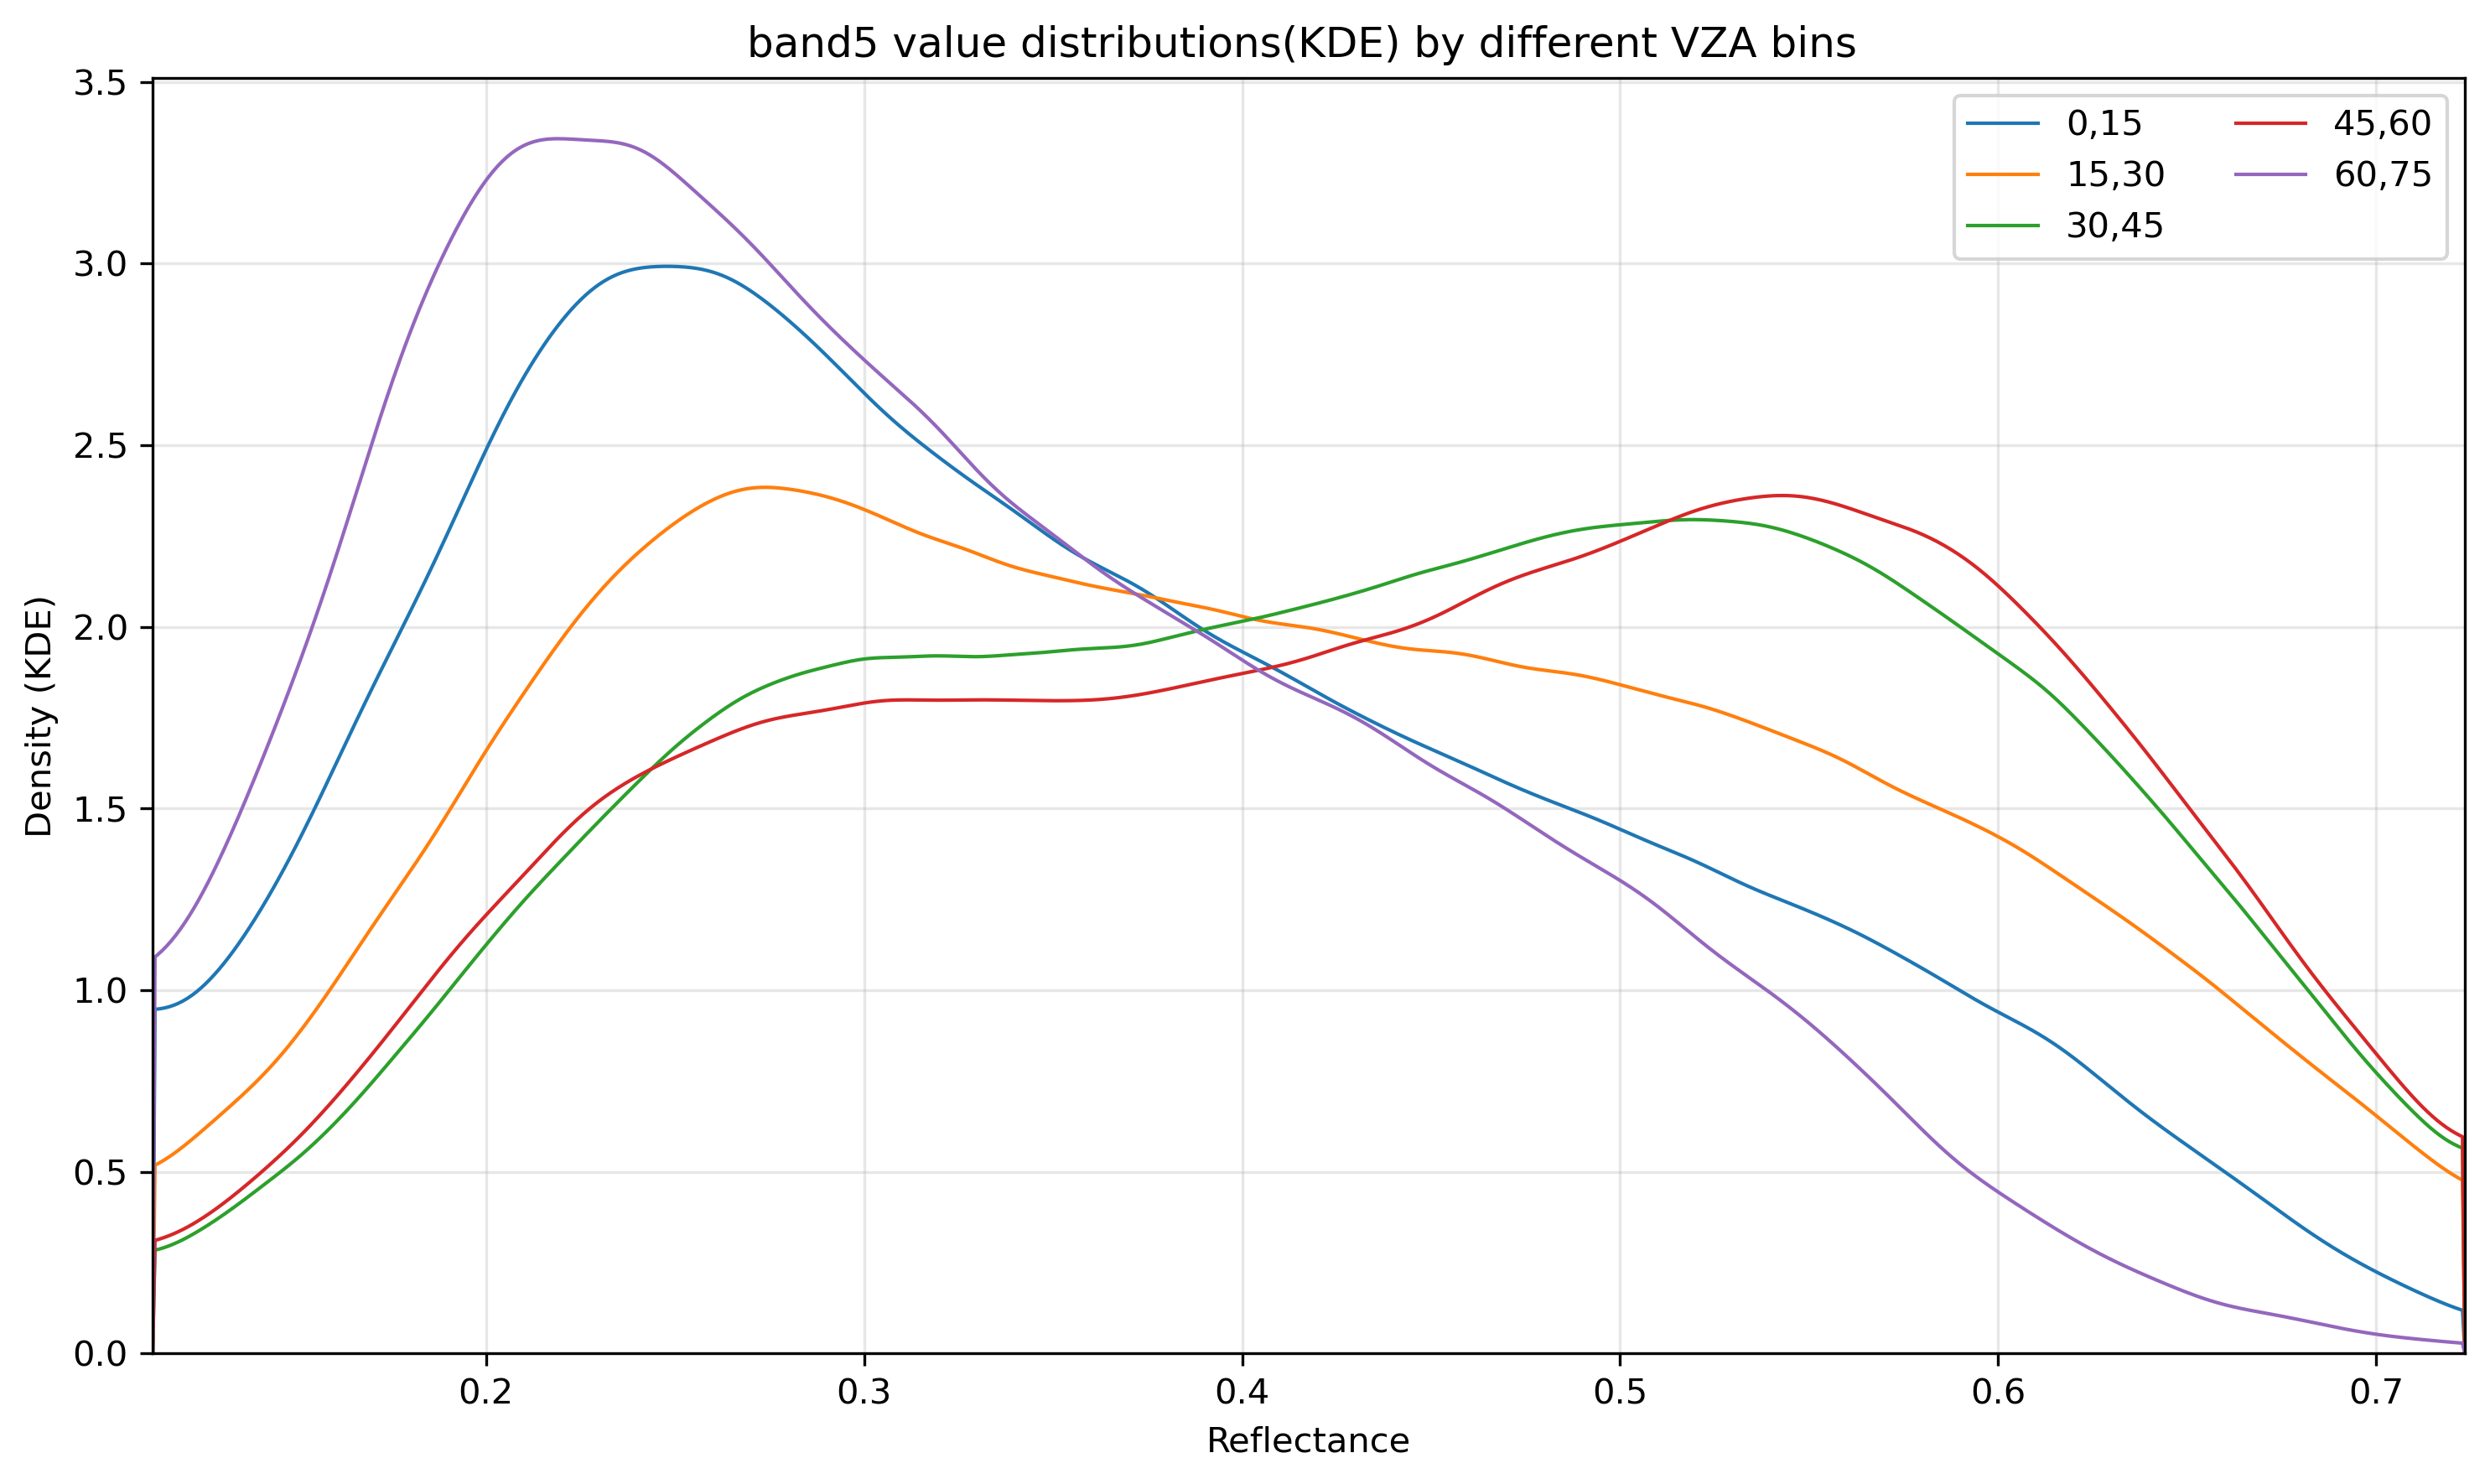

In [50]:
vaa_bins = [(0,45),(45,90),(90,135),(135,180)]

for band in [f"band{i}" for i in range(1,6)]:
    angle_kde_plot(dataframe, band=band, bins=vaa_bins, points=1000, linewidth=1, colors=None, dpi=300, xlim=None)

[(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315)]
0.0028277095407247543 0.08164452016353607


/tmp/ipykernel_371621/2631117297.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(y_pdf, x_grid)
/tmp/ipykernel_371621/2631117297.py:140: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_k.show()


0.010450415313243866 0.19510677456855774
0.004672456998378038 0.11847195029258728
0.03452929109334946 0.3790273070335388
0.11176793277263641 0.7234895825386047


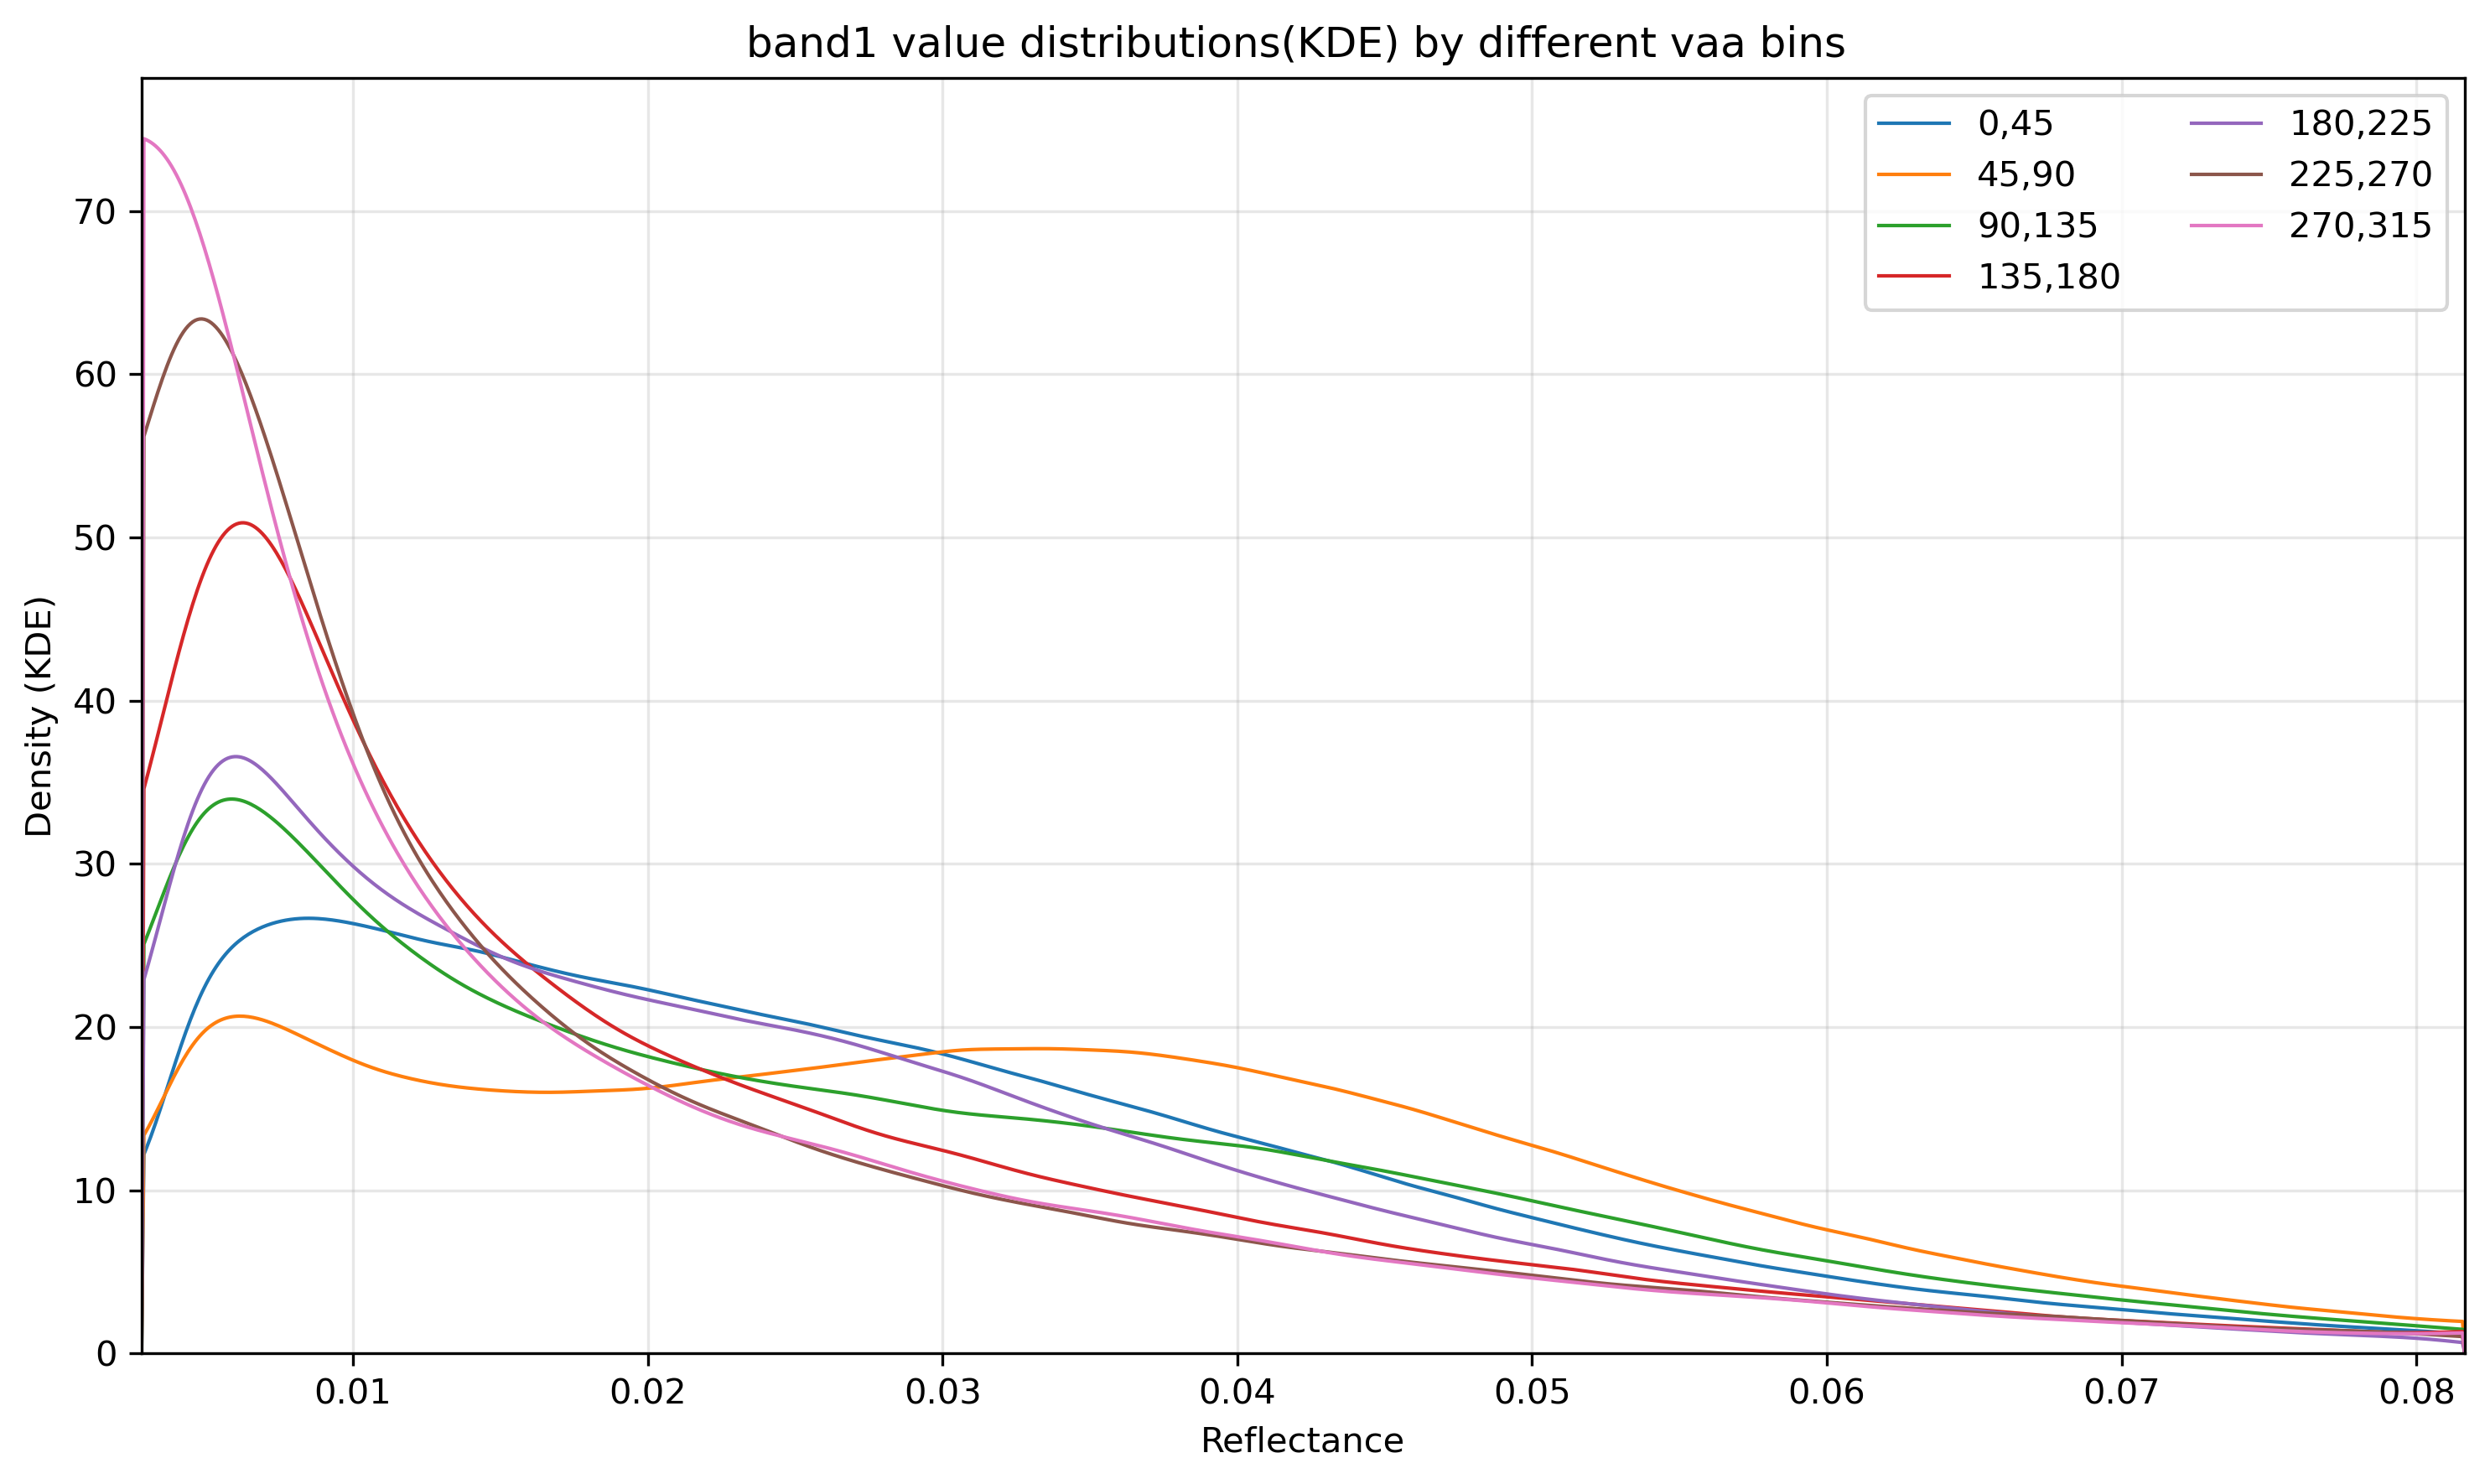

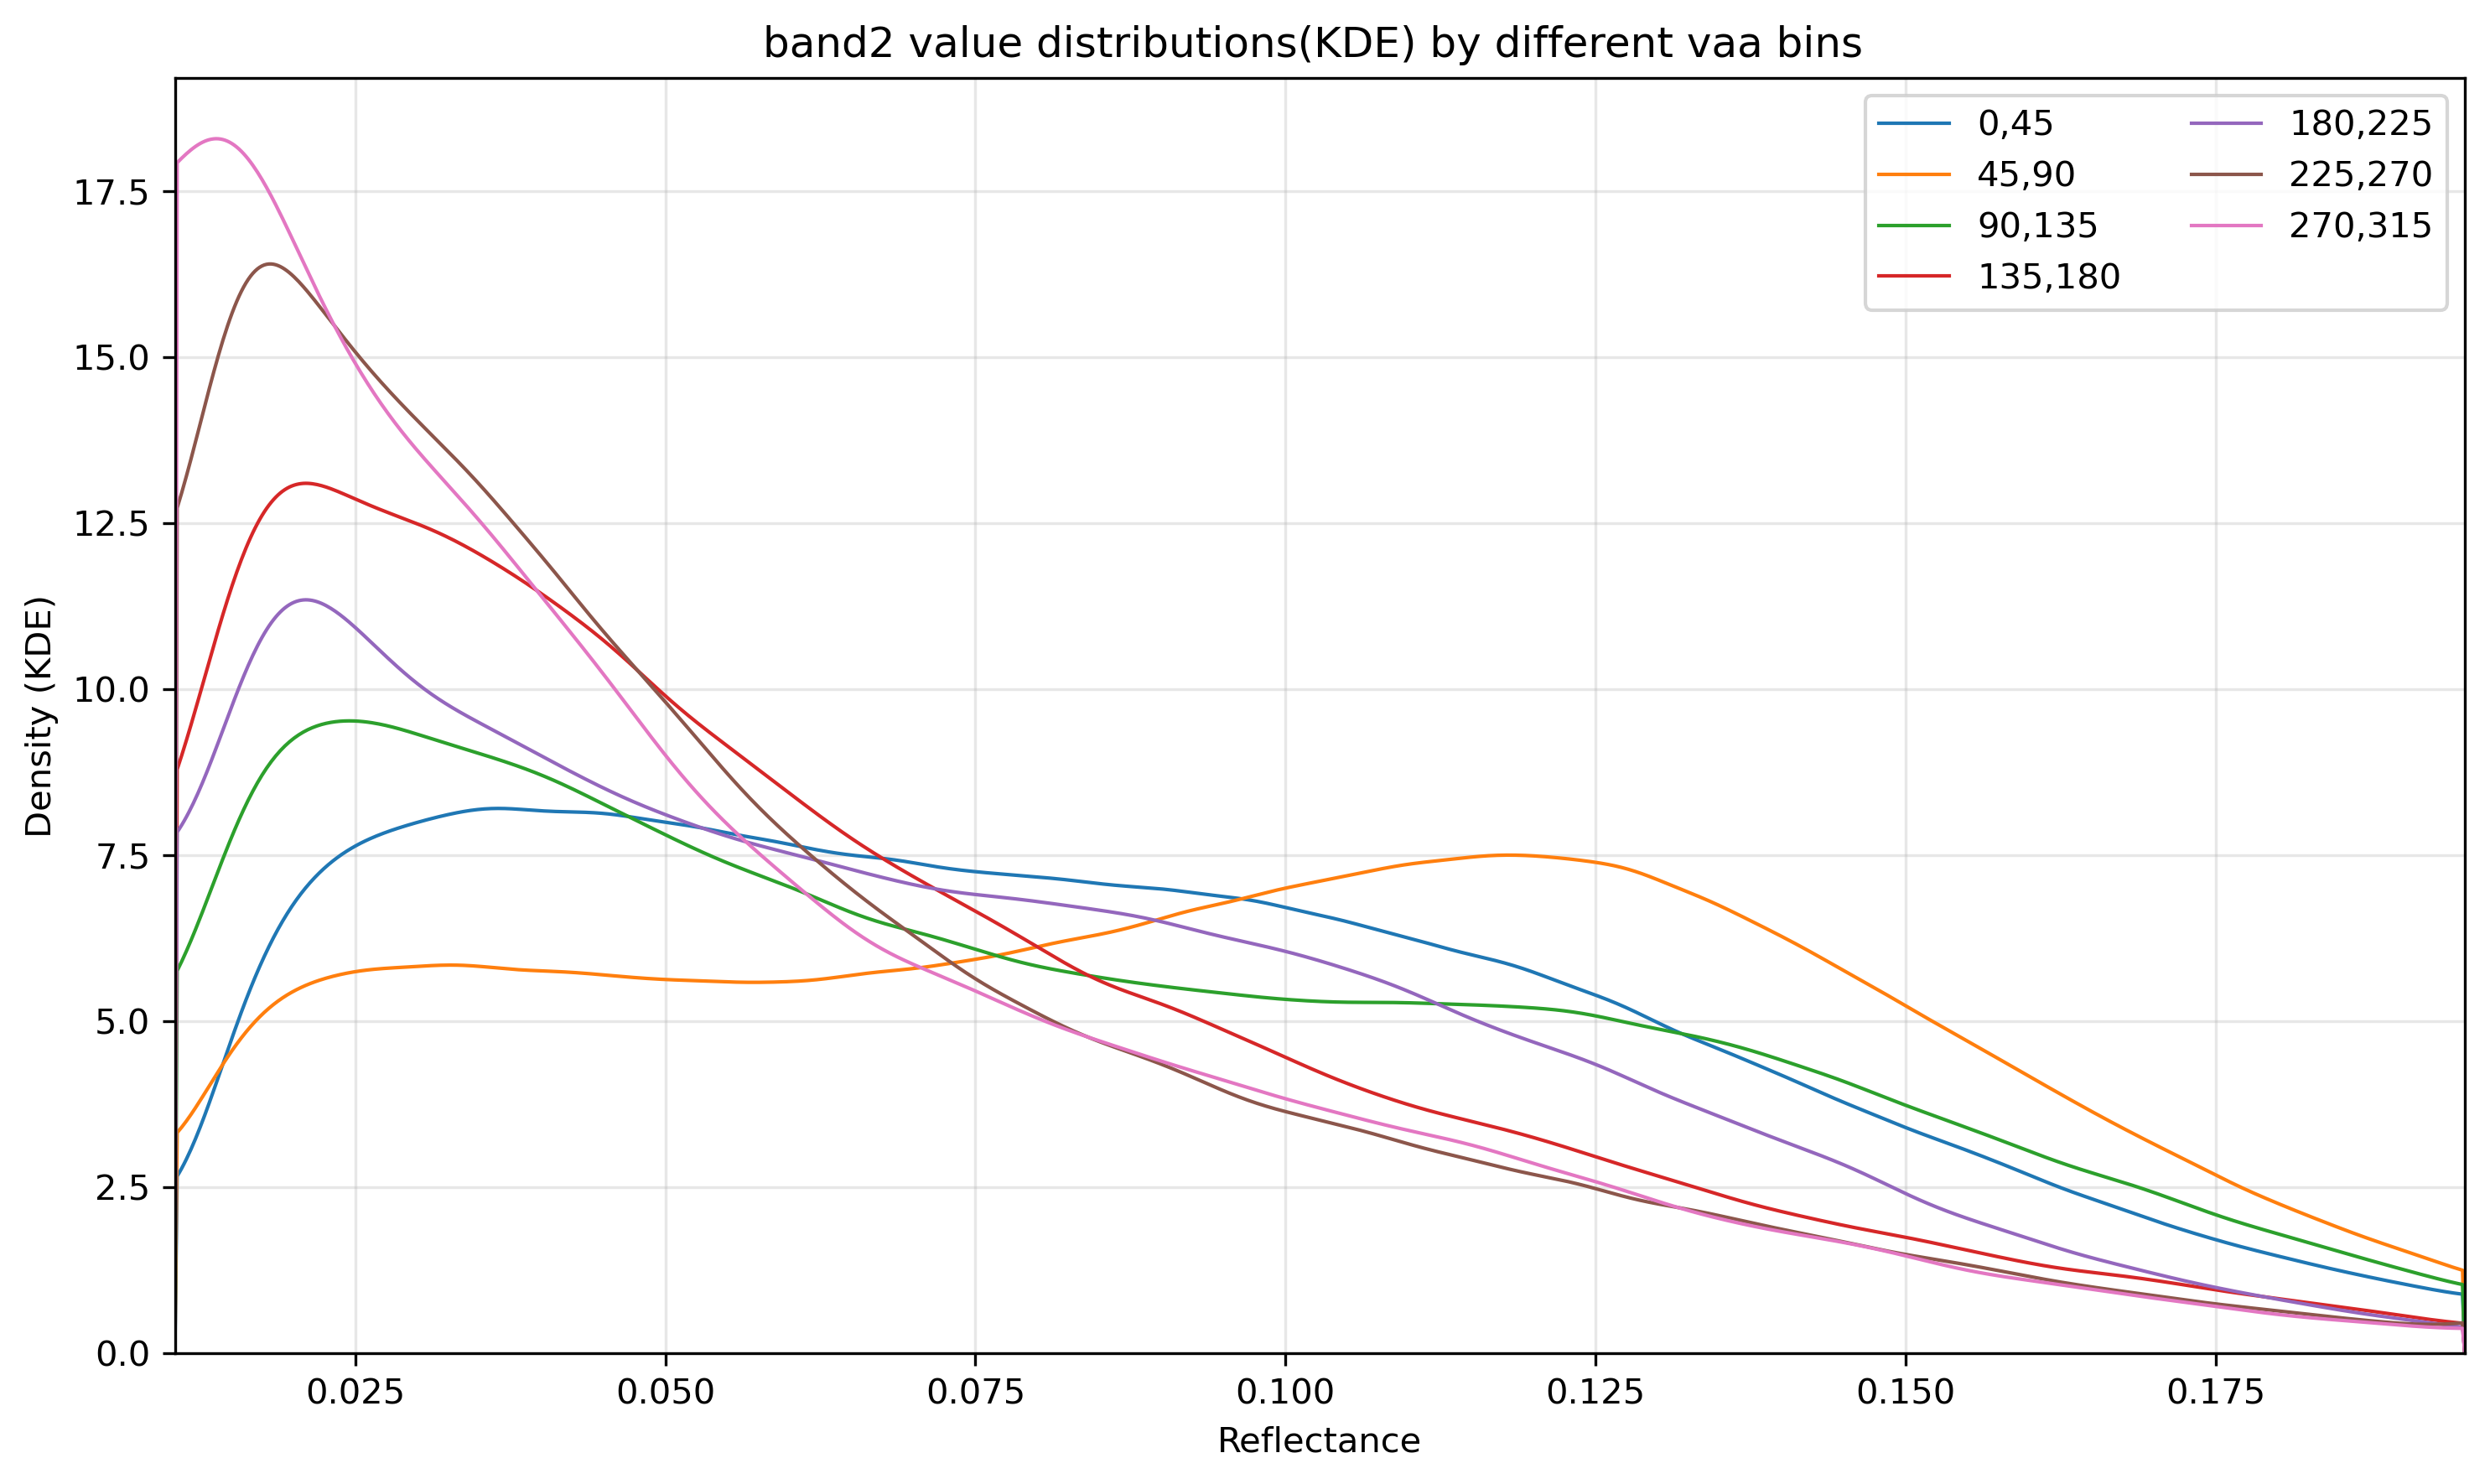

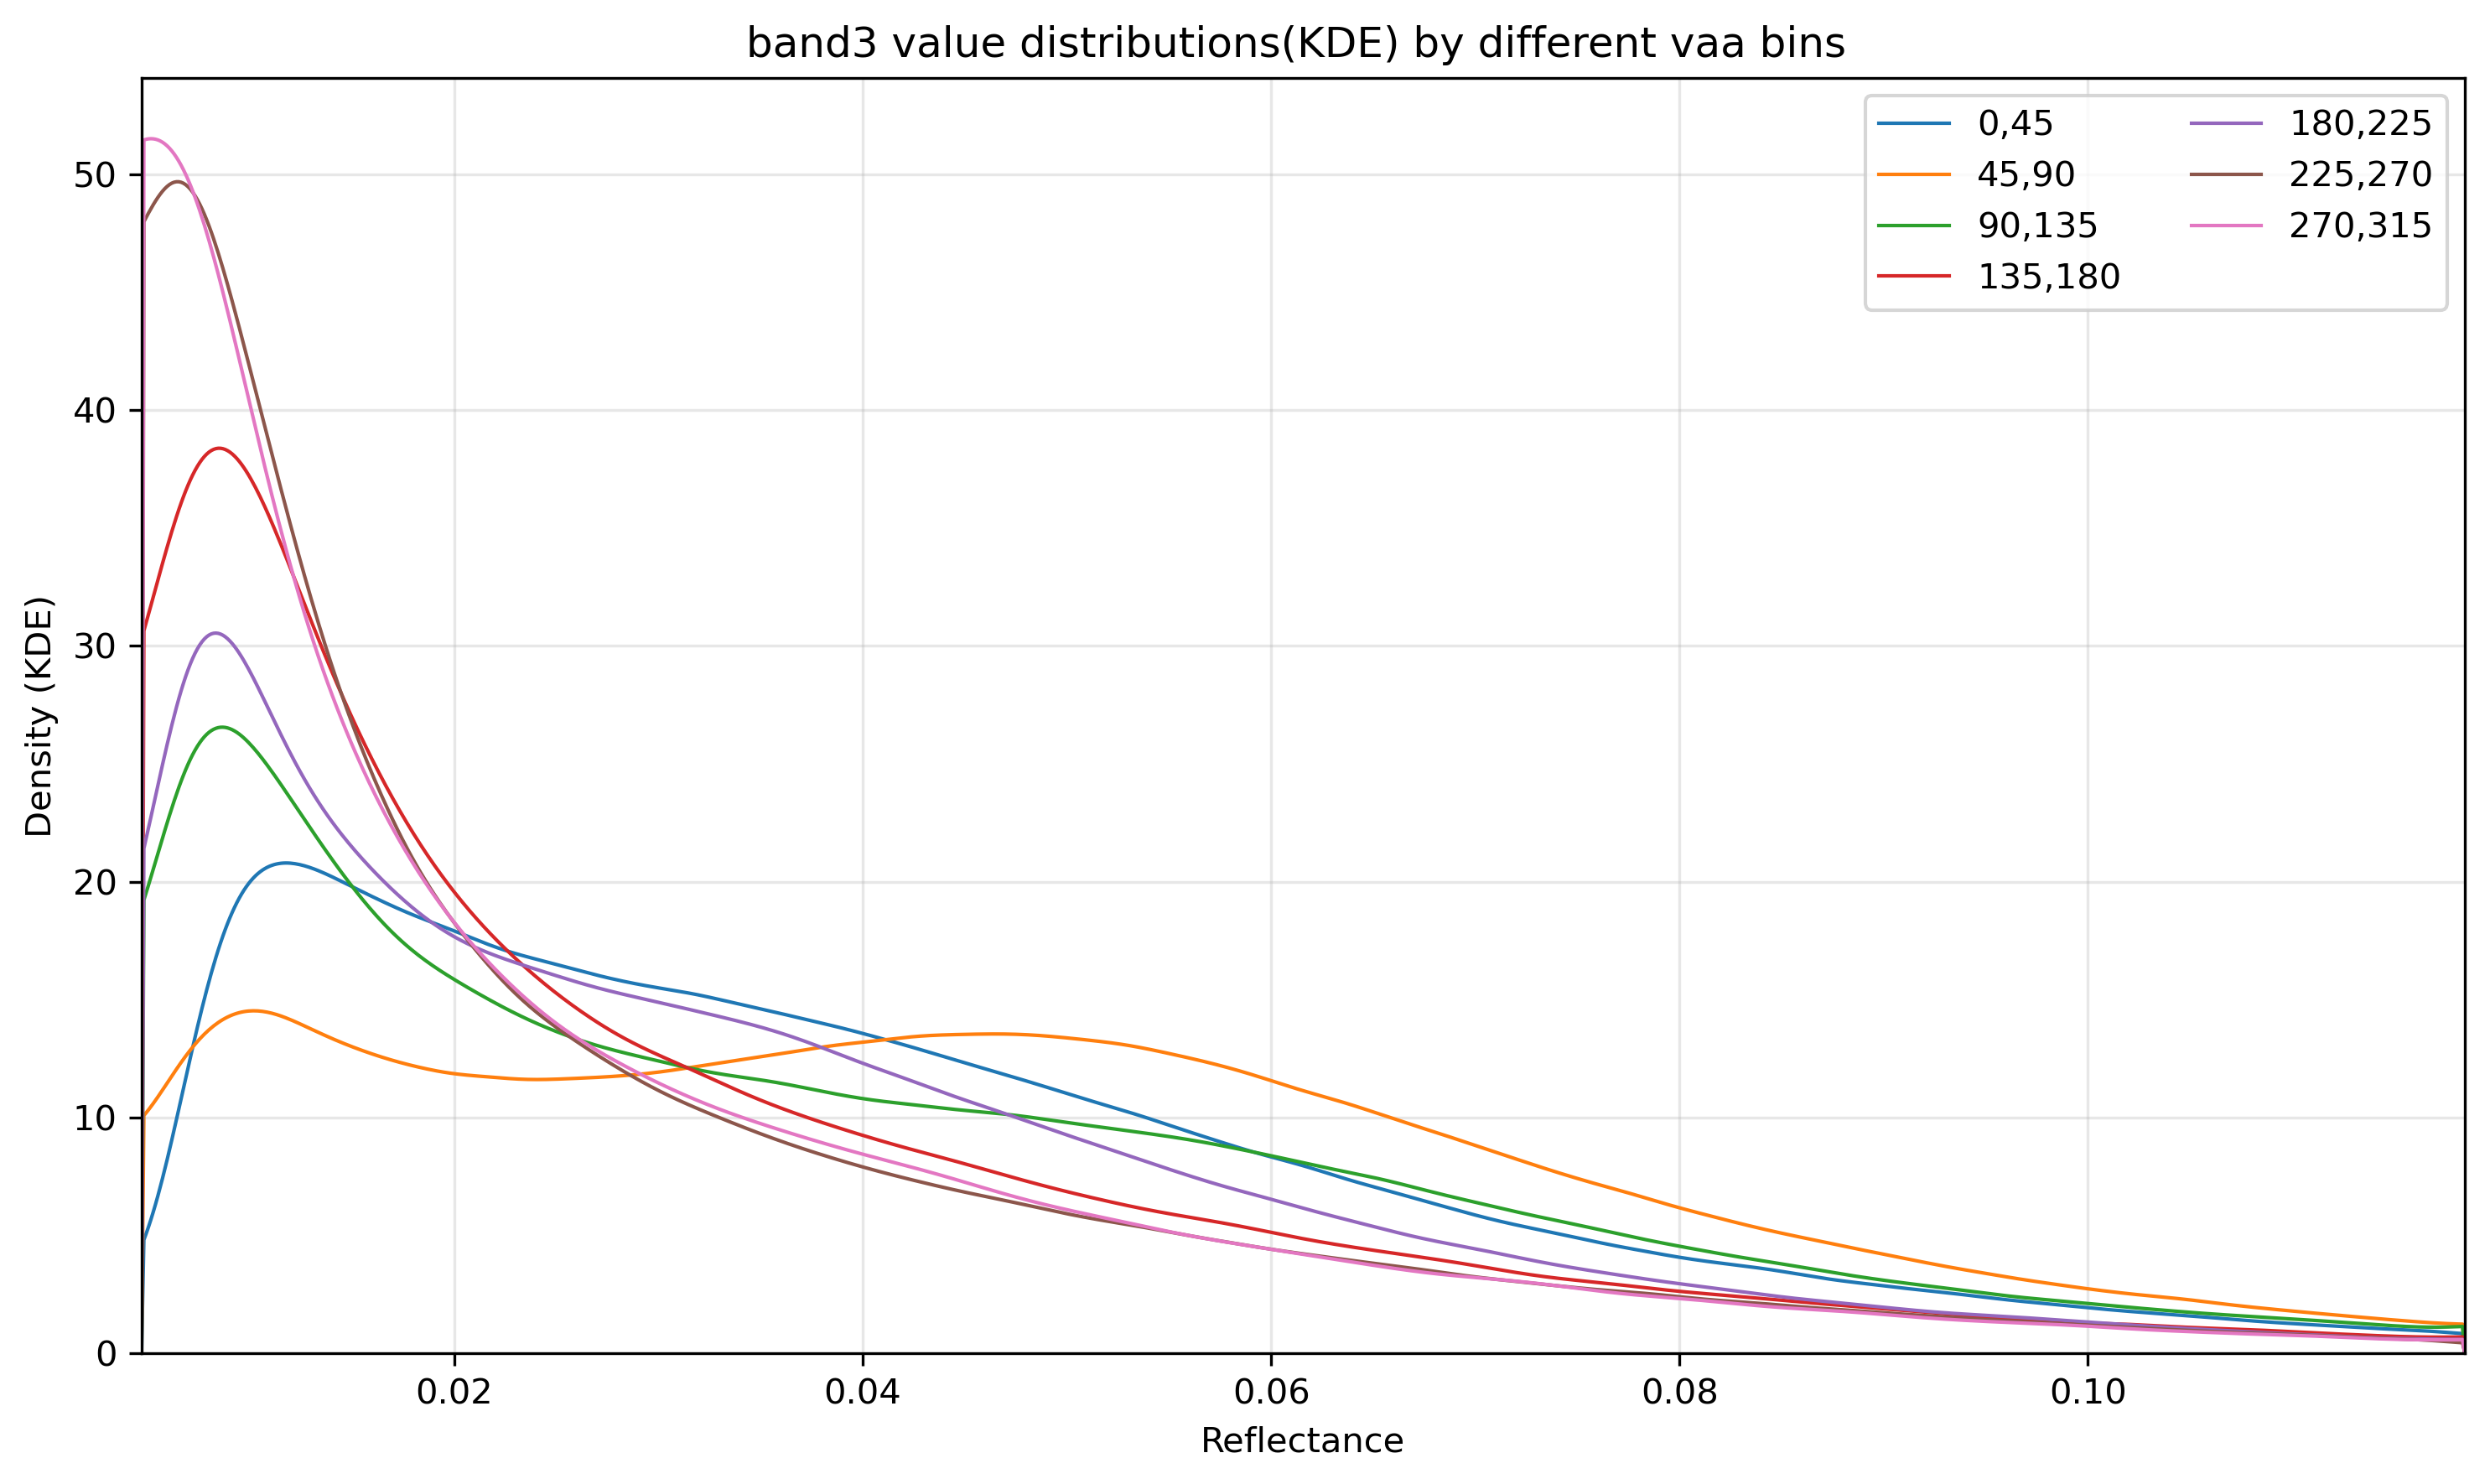

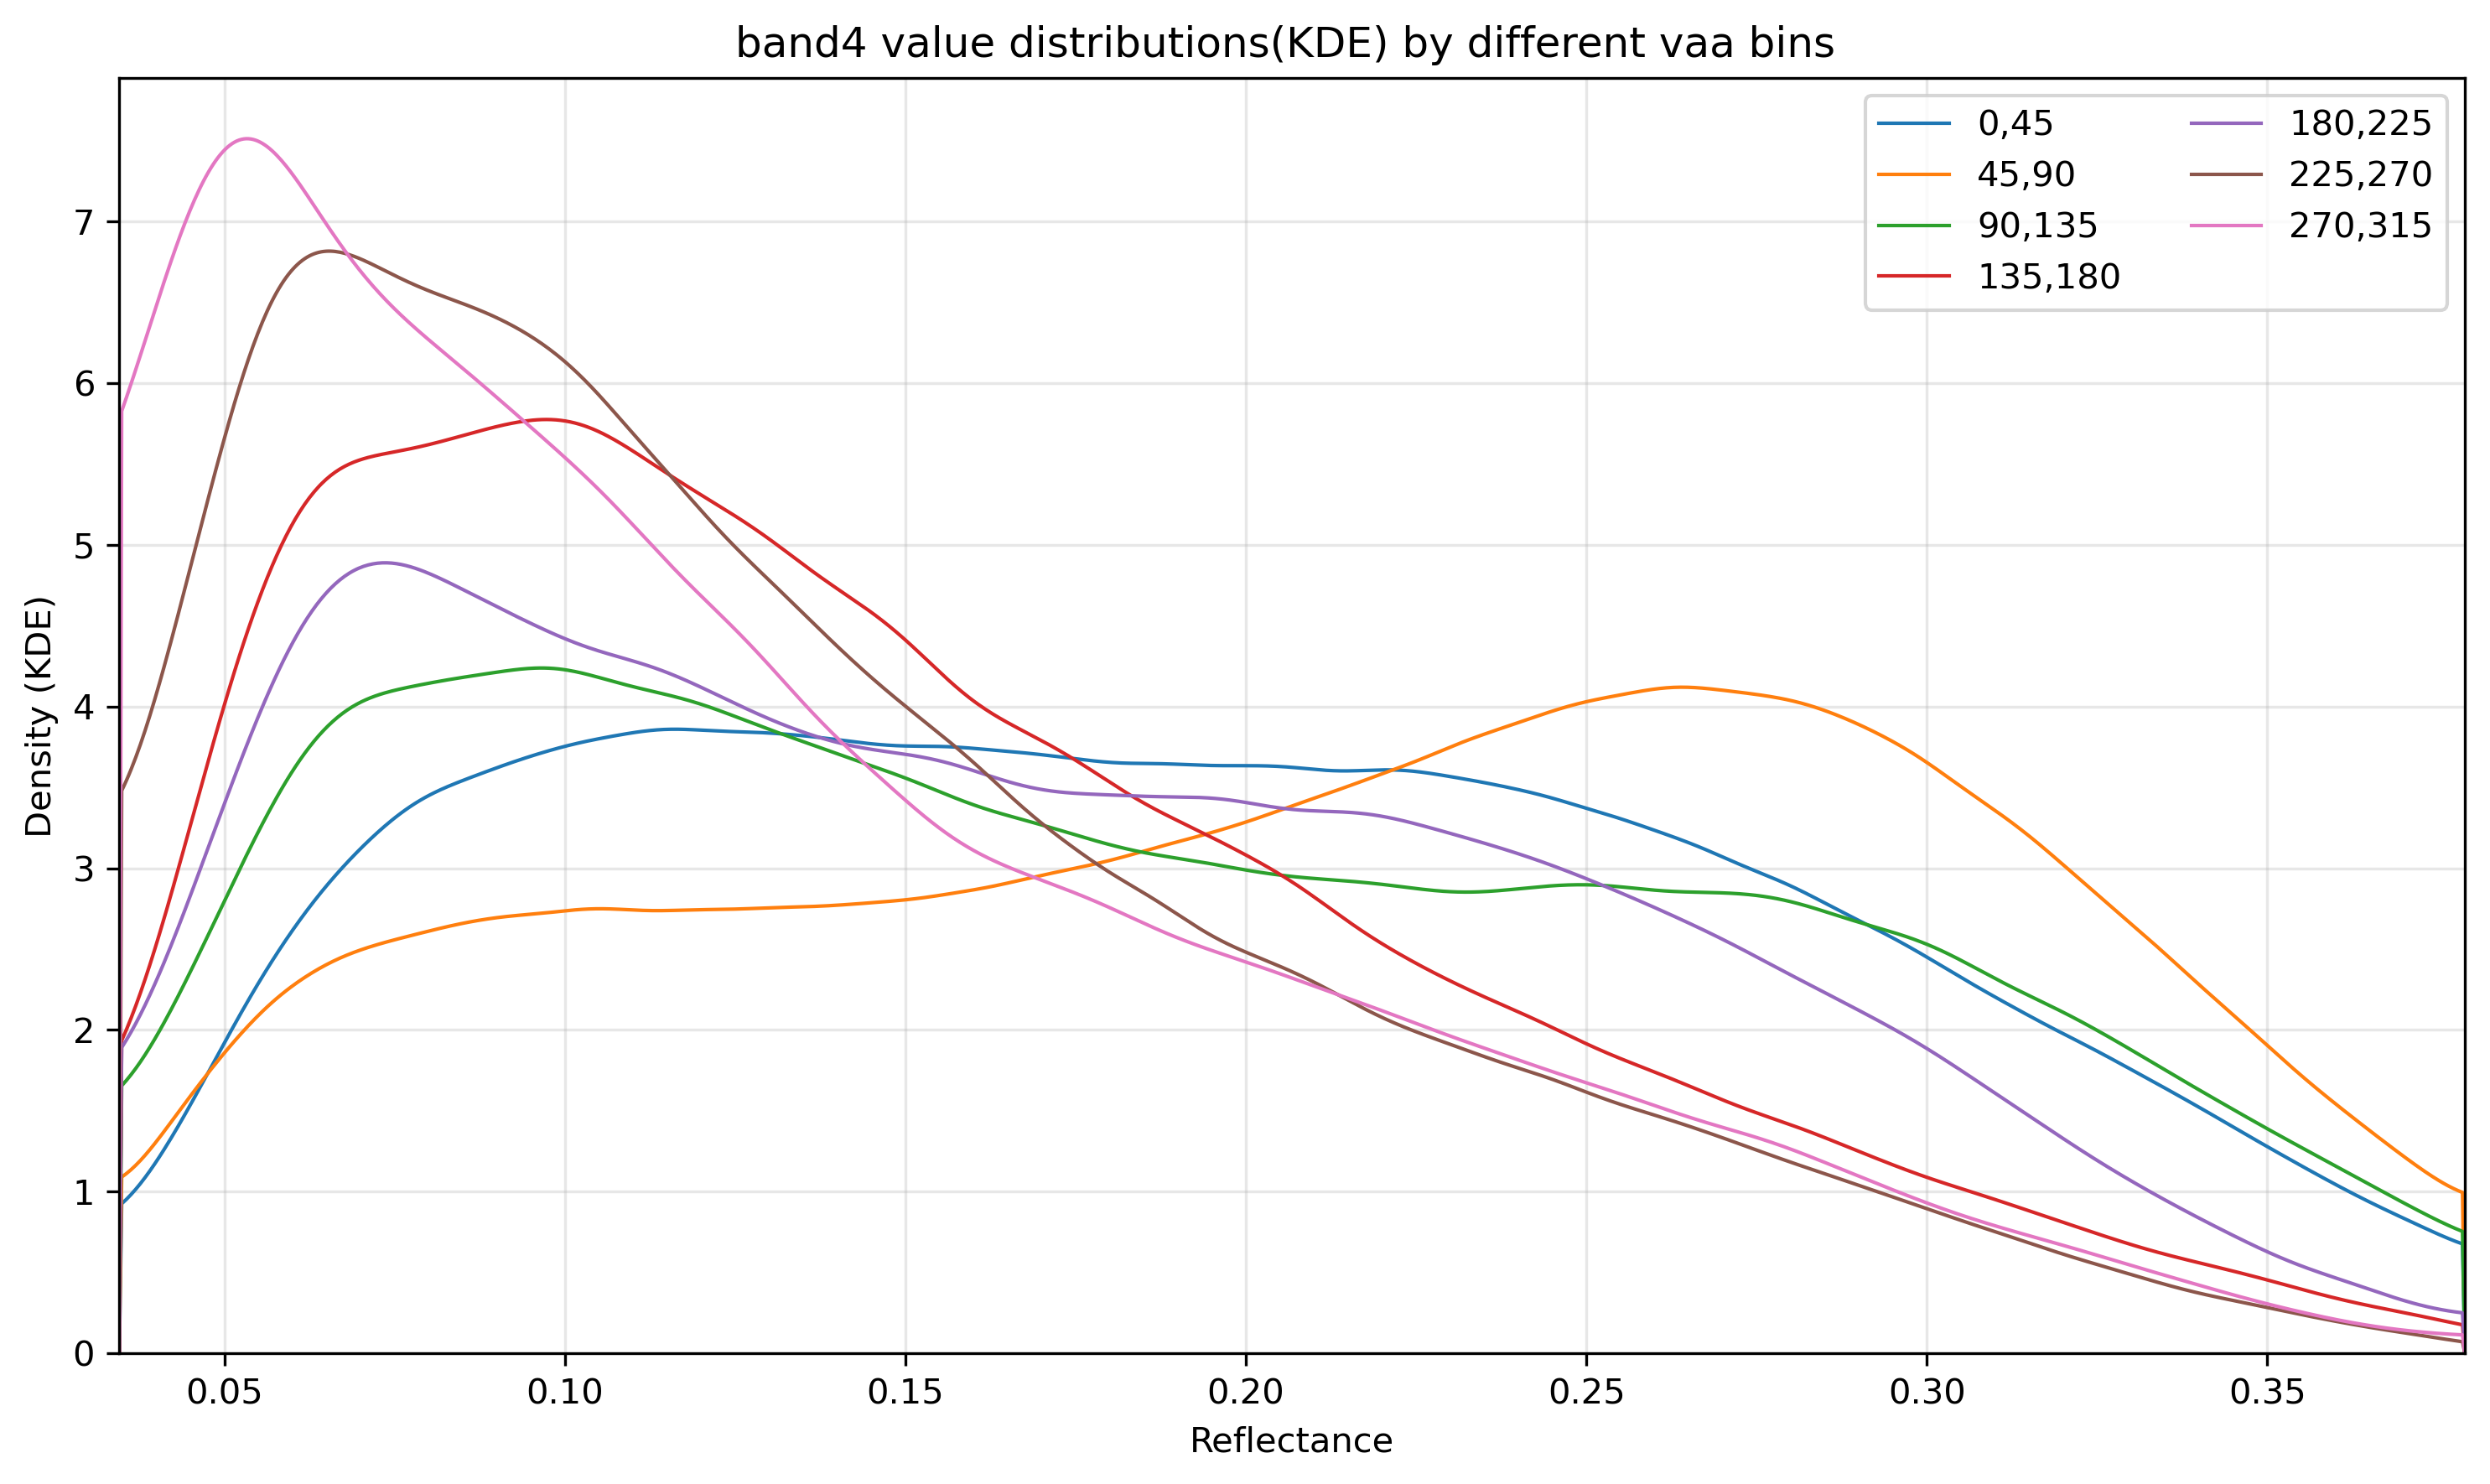

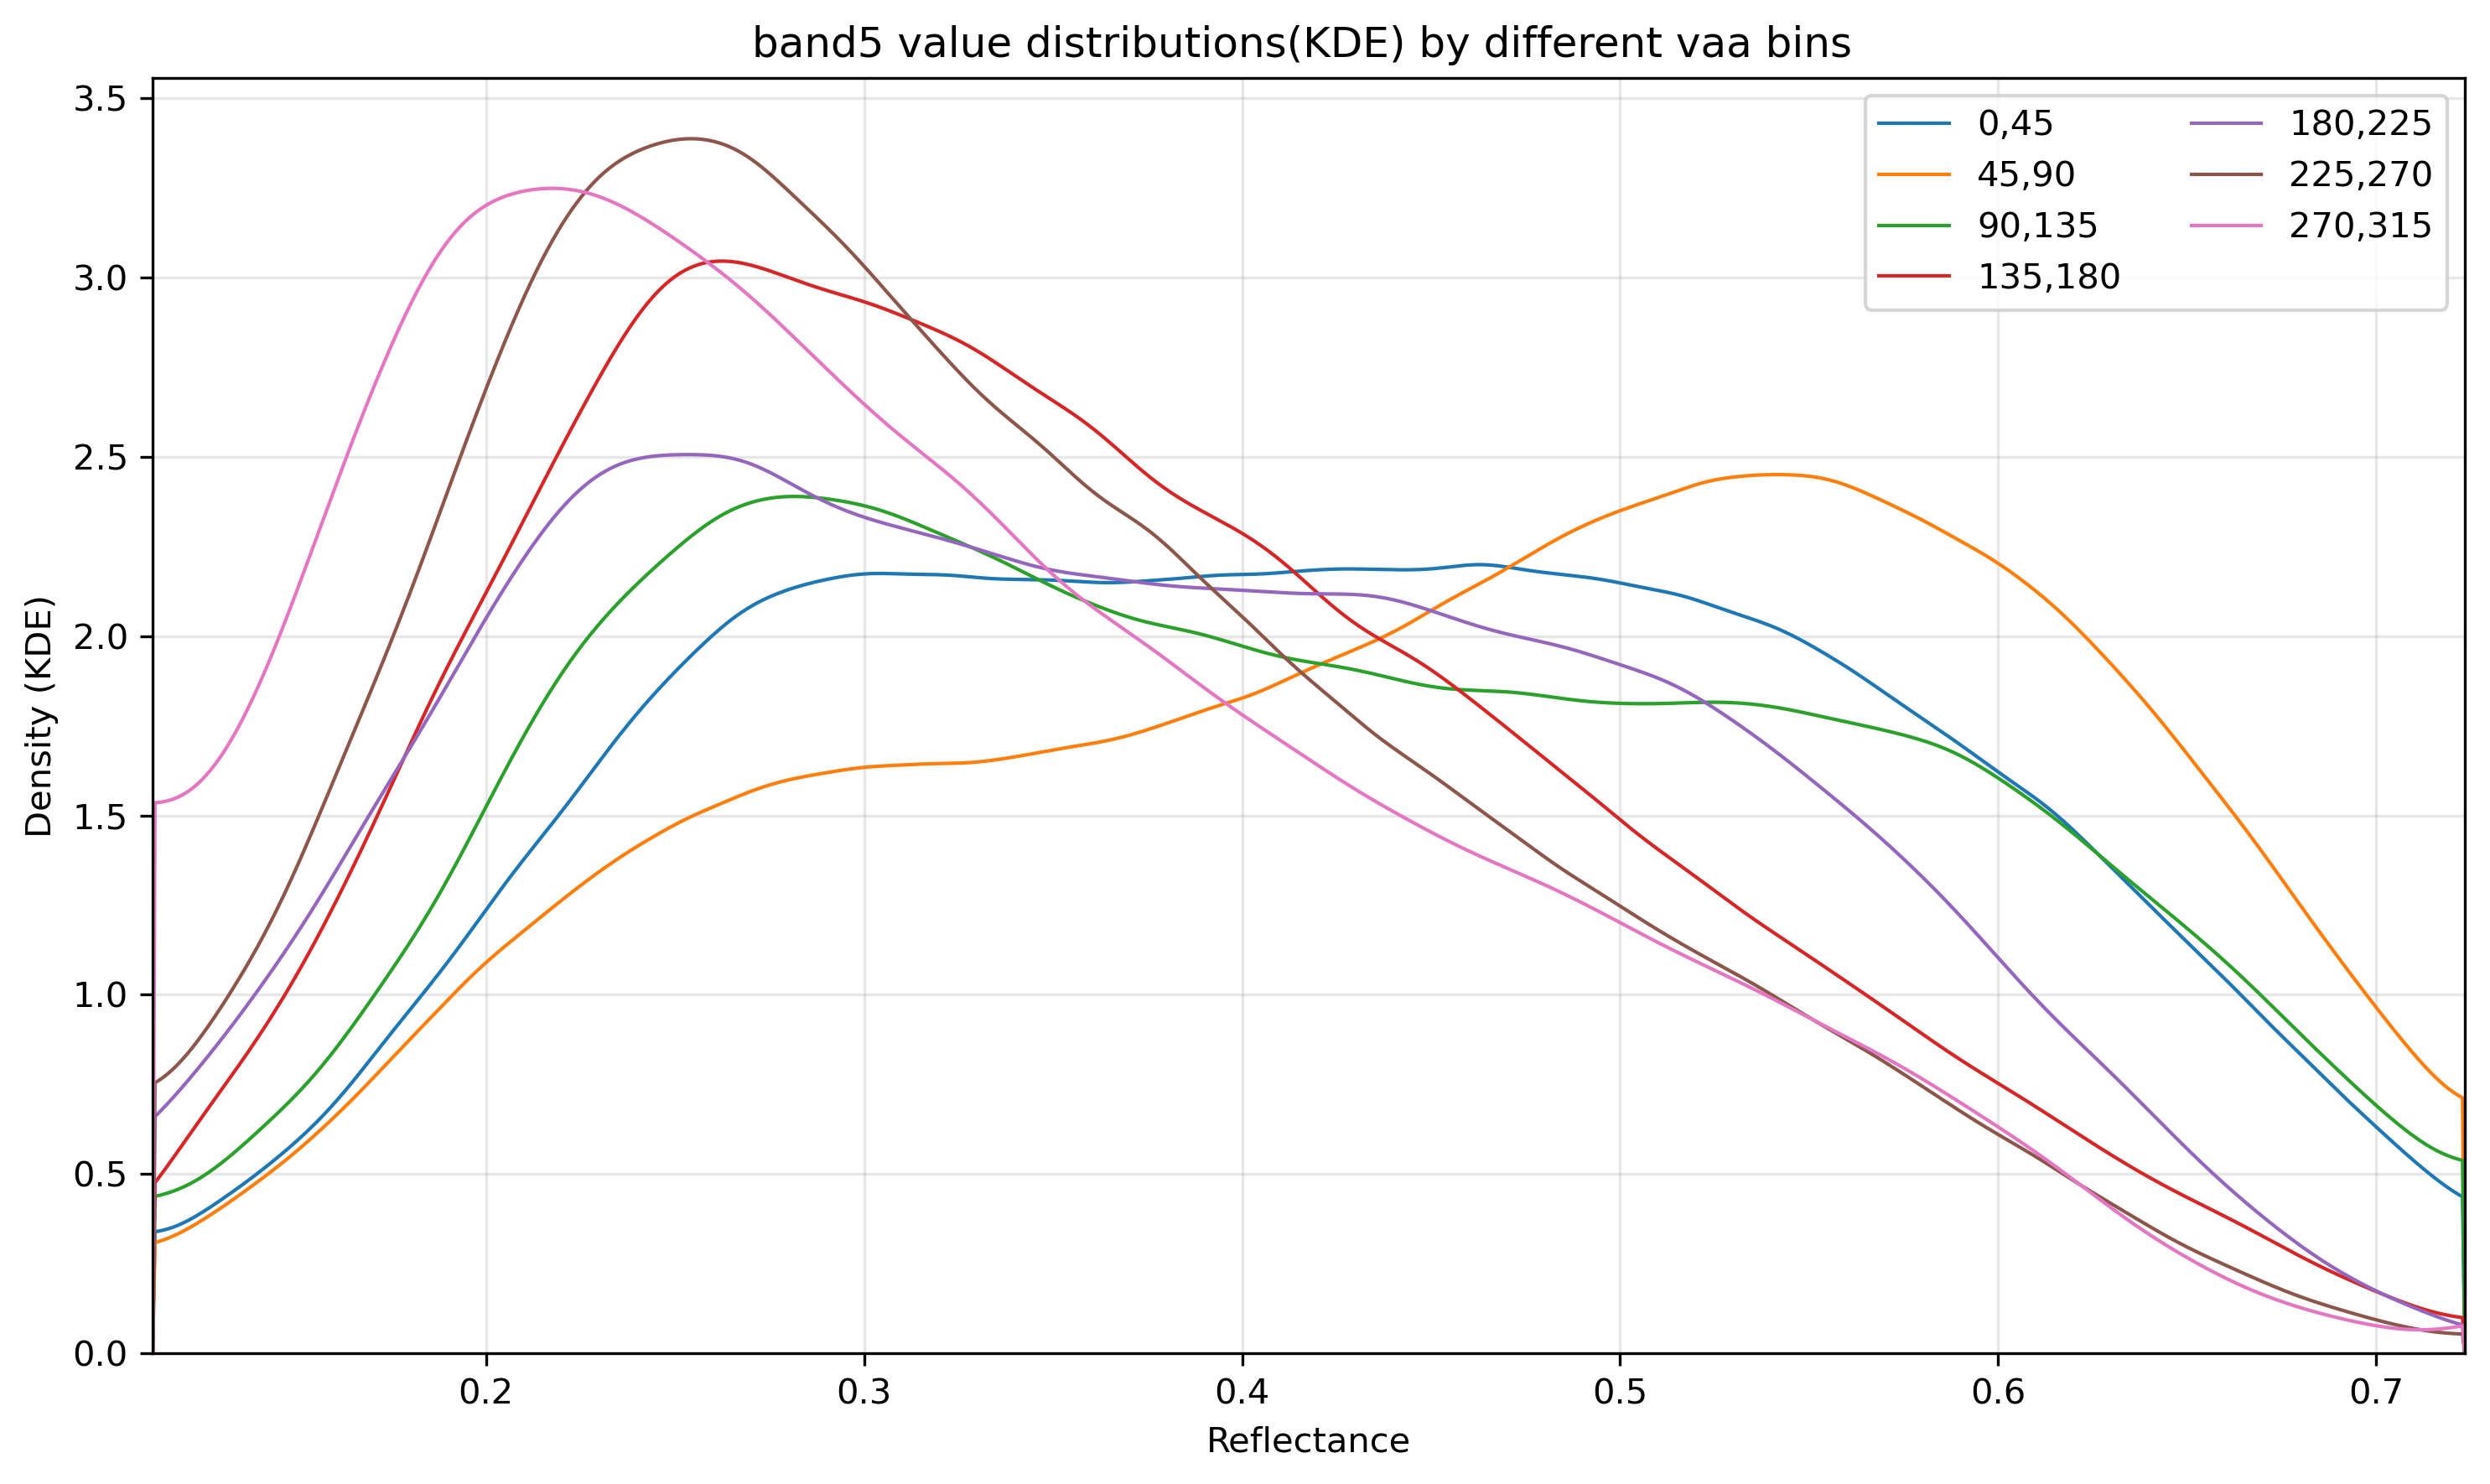

In [59]:
vaa_bins = [(i-45, i) for i in   range(45,360,45)]
print(vaa_bins)
for band in [f"band{i}" for i in range(1,6)]:
    angle_kde_plot(dataframe, band=band, bins=vaa_bins, points=1000, linewidth=1, colors=None, dpi=300, xlim=None, angle='vaa')